In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Reused code
def get_sinusoid_encoding_table(n_position, d_hid):
    def get_angle(pos, i):
        return pos / math.pow(10000, (2 * (i // 2)) / d_hid)
    table = np.array([[get_angle(pos, i) for i in range(d_hid)] for pos in range(n_position)])
    table[:, 0::2] = np.sin(table[:, 0::2])
    table[:, 1::2] = np.cos(table[:, 1::2])
    return torch.FloatTensor(table)

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=128):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)   
        x = x.flatten(2)  
        x = x.transpose(1, 2)   
        return x


In [ ]:
# Reused code
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = math.sqrt(self.head_dim)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
    
    def forward(self, x, return_attn=False):
        B, N, D = x.shape
        qkv = self.qkv(x)  # (B, N, 3*D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn_scores = (q @ k.transpose(-2, -1)) / self.scale   
        attn = attn_scores.softmax(dim=-1)
        if return_attn:
            self.last_attn = attn.detach()
        attn = self.attn_drop(attn)
        out = attn @ v   
        out = out.transpose(1, 2).reshape(B, N, D)
        out = self.proj(out)
        out = self.proj_drop(out)
        if return_attn:
            return out, attn
        return out


# Differential Multi-Head Attention
class DiffMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1, lambda_init=0.8):
        """
        Class module to implement the differential attention mechanism.
        project input features to obtain Q and K vectors which are split into two halves,
        compute two separate attention maps, and returns the (softmax(A1) - λ softmax(A2)) weighted output.
        assert requirement of embed_dim is divisible by 2*num_heads.
        """
        super(DiffMultiHeadAttention, self).__init__()
        assert embed_dim % (2 * num_heads) == 0, "embed_dim must be divisible by 2*num_heads for differential attention."
        self.num_heads = num_heads
        self.head_dim = embed_dim // (2 * num_heads)
        self.all_head_dim = num_heads * 2 * self.head_dim  
        self.scale = math.sqrt(self.head_dim)
        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        self.lam = nn.Parameter(torch.tensor(0.8))
        self.lambda_init = lambda_init  
        self.norm = nn.GroupNorm(num_groups=num_heads, num_channels=embed_dim)
        
    def forward(self, x):
        B, N, C = x.shape
        q = self.q(x).view(B, N, self.num_heads, 2 * self.head_dim).transpose(1, 2) 
        k = self.k(x).view(B, N, self.num_heads, 2 * self.head_dim).transpose(1, 2)
        v = self.v(x).view(B, N, self.num_heads, 2 * self.head_dim).transpose(1, 2)
        Q1, Q2 = q[..., :self.head_dim], q[..., self.head_dim:]
        K1, K2 = k[..., :self.head_dim], k[..., self.head_dim:]
        attn_scores1 = (Q1 @ K1.transpose(-2, -1)) / self.scale  
        attn_scores2 = (Q2 @ K2.transpose(-2, -1)) / self.scale
        attn1 = attn_scores1.softmax(dim=-1)
        attn2 = attn_scores2.softmax(dim=-1)
        attn = attn1 - self.lam * attn2
        attn = self.attn_drop(attn)
        out = out.transpose(1, 2).reshape(B, N, self.all_head_dim)  
        out = out.transpose(1, 2)   
        out = self.norm(out)        
        out = out.transpose(1, 2)   
        out = out * (1 - self.lambda_init)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out


# Reused code (modified to optionally use DiffMultiHeadAttention)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1, use_diff_attn=False):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        if use_diff_attn:
            self.attn = DiffMultiHeadAttention(embed_dim, num_heads, dropout=dropout)
        else:
            self.attn = MultiHeadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, return_attn=False):
        if return_attn:
            attn_out, attn = self.attn(self.norm1(x), return_attn=True)
            x = x + attn_out
            x = x + self.mlp(self.norm2(x))
            return x, attn
        else:
            x = x + self.attn(self.norm1(x))
            x = x + self.mlp(self.norm2(x))
            return x

# Reused code (modified to optionally use Diff Attention)
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10, embed_dim=128, depth=6, num_heads=4, mlp_ratio=4.0, dropout=0.1, pos_emb_type="1d", use_diff_attn=True):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        if pos_emb_type == "none":
            self.pos_embed = None
        elif pos_emb_type == "1d":
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
        elif pos_emb_type == "2d":
            grid_size = int(math.sqrt(num_patches))
            self.row_embed = nn.Parameter(torch.zeros(1, grid_size, embed_dim // 2))
            self.col_embed = nn.Parameter(torch.zeros(1, grid_size, embed_dim // 2))
            nn.init.trunc_normal_(self.row_embed, std=0.02)
            nn.init.trunc_normal_(self.col_embed, std=0.02)
        elif pos_emb_type == "sinusoidal":
            pos_embed = get_sinusoid_encoding_table(num_patches + 1, embed_dim).unsqueeze(0)
            self.register_buffer("pos_embed", pos_embed)
        else:
            raise ValueError("Invalid positional embedding type")
        self.pos_emb_type = pos_emb_type
        self.blocks = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_ratio, dropout, use_diff_attn=use_diff_attn)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.head.weight.data.normal_(mean=0.0, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_emb_type == "none":
            pass
        elif self.pos_emb_type in ["1d", "sinusoidal"]:
            x = x + self.pos_embed
        elif self.pos_emb_type == "2d":
            grid_size = int(math.sqrt(x.shape[1] - 1))
            pos_patch = torch.cat((
                self.row_embed.repeat(1, grid_size, 1),
                self.col_embed.repeat(1, grid_size, 1)
            ), dim=-1)
            pos = torch.cat((torch.zeros(1, 1, pos_patch.shape[-1], device=x.device), pos_patch), dim=1)
            x = x + pos

        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        cls_out = x[:, 0]
        logits = self.head(cls_out)
        return logits

    def get_last_attention_map(self, x):
        device = x.device
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_emb_type in ["1d", "sinusoidal"]:
            x = x + self.pos_embed
        elif self.pos_emb_type == "2d":
            grid_size = int(math.sqrt(x.shape[1]-1))
            pos_patch = torch.cat((
                self.row_embed.repeat(1, grid_size, 1),
                self.col_embed.repeat(1, grid_size, 1)
            ), dim=-1)
            pos = torch.cat((torch.zeros(1, 1, pos_patch.shape[-1], device=device), pos_patch), dim=1)
            x = x + pos
        x = self.dropout(x)
        for block in self.blocks[:-1]:
            x = block(x)
        last_block = self.blocks[-1]
        x_norm = last_block.norm1(x)
        out_attn = last_block.attn(x_norm)   
        return None   

In [4]:
# Reused code
def get_dataloaders(batch_size=128, augment=False, augmentation_type="A"):
    if augment:
        if augmentation_type == "A":   
            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
            ])
        elif augmentation_type == "B":   
            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
            ])
        elif augmentation_type == "C":   
            transform_train = transforms.Compose([
                transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                transforms.ToTensor(),
            ])
        else:
            transform_train = transforms.ToTensor()
    else:
        transform_train = transforms.ToTensor()

    transform_test = transforms.ToTensor()
    trainset = torchvision.datasets.CIFAR10(root='./cifar-10-batches-py', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./cifar-10-batches-py', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader

# Reused code
def train_epoch(model, device, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

# Reused code
def evaluate(model, device, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    loss_total = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss_total += criterion(outputs, targets).item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += predicted.eq(targets).cpu().sum().item()
    return loss_total / len(dataloader), 100. * correct / total

# Reused code
def run_training(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)
    train_loader, test_loader = get_dataloaders(
        batch_size=config.get("batch_size", 128),
        augment=config.get("augment", False),
        augmentation_type=config.get("augmentation_type", "A")
    )
    model = VisionTransformer(
        img_size=32,
        patch_size=config.get("patch_size", 4),
        in_channels=3,
        num_classes=10,
        embed_dim=config.get("embed_dim", 128),
        depth=config.get("depth", 6),
        num_heads=config.get("num_heads", 4),
        mlp_ratio=config.get("mlp_ratio", 4.0),
        dropout=config.get("dropout", 0.1),
        pos_emb_type=config.get("pos_emb_type", "1d")
    )
    model = model.to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config.get("lr", 1e-3), weight_decay=config.get("weight_decay", 5e-2))
    num_epochs = config.get("num_epochs", 50)
    train_losses, test_losses, test_accs = [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, device, train_loader, criterion, optimizer)
        test_loss, test_acc = evaluate(model, device, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"Epoch {epoch+1}/{num_epochs}: Train loss = {train_loss:.4f}, Test loss = {test_loss:.4f}, Test acc = {test_acc:.2f}%")
    return train_losses, test_losses, test_accs, model

In [5]:
# Reused code
def plot_loss_curves(train_losses, test_losses, title="Loss Curves"):
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_accuracy(test_accs, title="Test Accuracy"):
    plt.figure()
    plt.plot(test_accs, label="Test Accuracy")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

# Patch Size


--- Training with patch size 2 ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0436, Test loss = 1.8332, Test acc = 32.26%
Epoch 2/50: Train loss = 1.8180, Test loss = 1.7002, Test acc = 38.03%
Epoch 3/50: Train loss = 1.6624, Test loss = 1.5827, Test acc = 43.58%
Epoch 4/50: Train loss = 1.5422, Test loss = 1.3730, Test acc = 50.48%
Epoch 5/50: Train loss = 1.4525, Test loss = 1.3665, Test acc = 51.46%
Epoch 6/50: Train loss = 1.3890, Test loss = 1.2889, Test acc = 53.98%
Epoch 7/50: Train loss = 1.3296, Test loss = 1.2260, Test acc = 56.00%
Epoch 8/50: Train loss = 1.2798, Test loss = 1.2221, Test acc = 56.20%
Epoch 9/50: Train loss = 1.2434, Test loss = 1.1192, Test acc = 59.65%
Epoch 10/50: Train loss = 1.2008, Test loss = 1.1071, Test acc = 60.75%
Epoch 11/50: Train loss = 1.1595, Test loss = 1.0988, Test acc = 60.60%
Epoch 12/50: Train loss = 1.1394, Test loss = 1.0518, Test acc = 62.60%
E

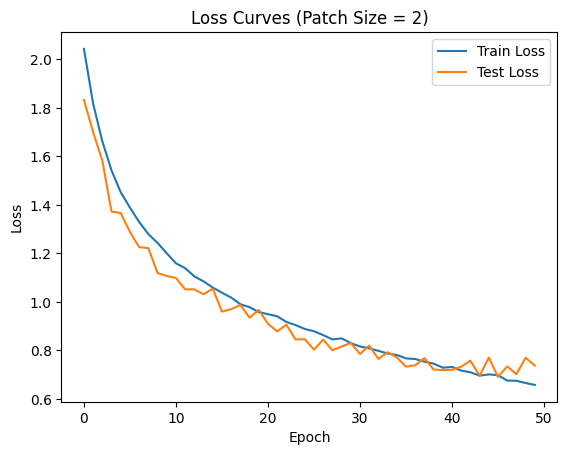

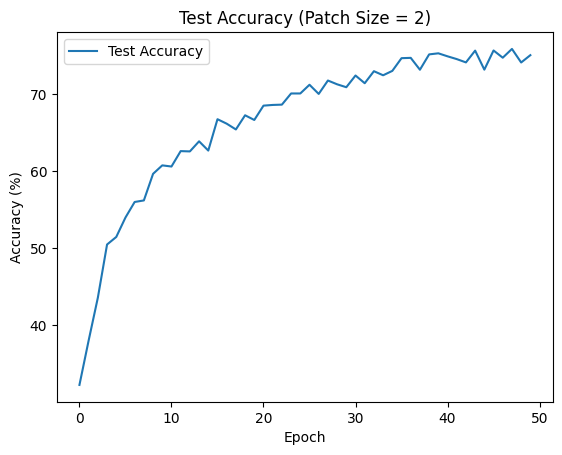


--- Training with patch size 4 ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0034, Test loss = 1.7662, Test acc = 33.92%
Epoch 2/50: Train loss = 1.7702, Test loss = 1.6501, Test acc = 40.09%
Epoch 3/50: Train loss = 1.6305, Test loss = 1.4673, Test acc = 46.44%
Epoch 4/50: Train loss = 1.5306, Test loss = 1.3653, Test acc = 50.31%
Epoch 5/50: Train loss = 1.4454, Test loss = 1.3313, Test acc = 52.50%
Epoch 6/50: Train loss = 1.3891, Test loss = 1.2565, Test acc = 54.48%
Epoch 7/50: Train loss = 1.3439, Test loss = 1.2151, Test acc = 55.82%
Epoch 8/50: Train loss = 1.3042, Test loss = 1.2146, Test acc = 55.80%
Epoch 9/50: Train loss = 1.2729, Test loss = 1.1555, Test acc = 57.90%
Epoch 10/50: Train loss = 1.2393, Test loss = 1.1263, Test acc = 58.66%
Epoch 11/50: Train loss = 1.2080, Test loss = 1.1203, Test acc = 59.03%
Epoch 12/50: Train loss = 1.1798, Test loss = 1.0663, Test acc = 61.34%
E

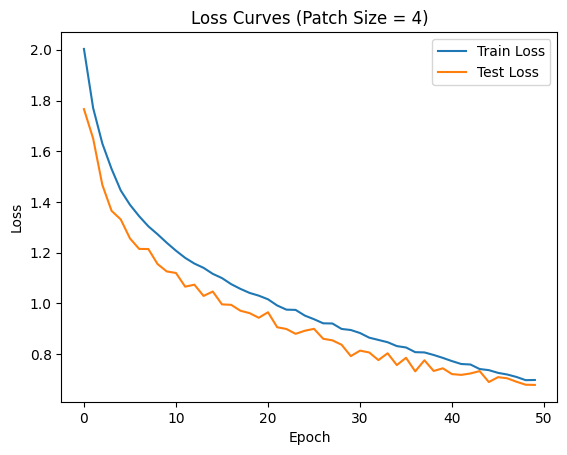

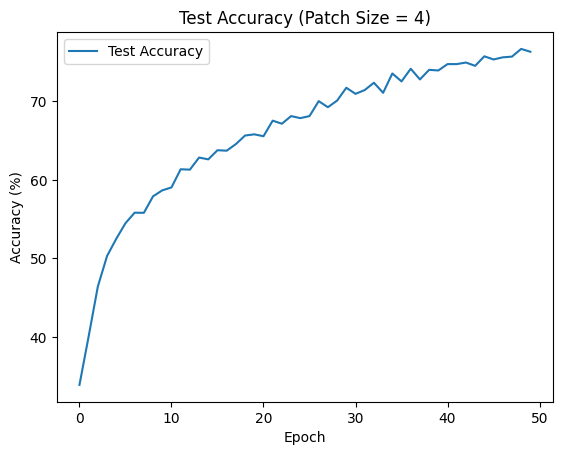


--- Training with patch size 8 ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0033, Test loss = 1.8005, Test acc = 33.38%
Epoch 2/50: Train loss = 1.7916, Test loss = 1.6589, Test acc = 39.19%
Epoch 3/50: Train loss = 1.6936, Test loss = 1.5645, Test acc = 43.20%
Epoch 4/50: Train loss = 1.6232, Test loss = 1.5214, Test acc = 45.24%
Epoch 5/50: Train loss = 1.5743, Test loss = 1.4564, Test acc = 47.55%
Epoch 6/50: Train loss = 1.5427, Test loss = 1.4107, Test acc = 49.53%
Epoch 7/50: Train loss = 1.5022, Test loss = 1.3652, Test acc = 51.08%
Epoch 8/50: Train loss = 1.4796, Test loss = 1.3382, Test acc = 51.86%
Epoch 9/50: Train loss = 1.4512, Test loss = 1.3587, Test acc = 51.36%
Epoch 10/50: Train loss = 1.4308, Test loss = 1.3296, Test acc = 52.04%
Epoch 11/50: Train loss = 1.4086, Test loss = 1.3118, Test acc = 53.08%
Epoch 12/50: Train loss = 1.3928, Test loss = 1.2797, Test acc = 53.82%
E

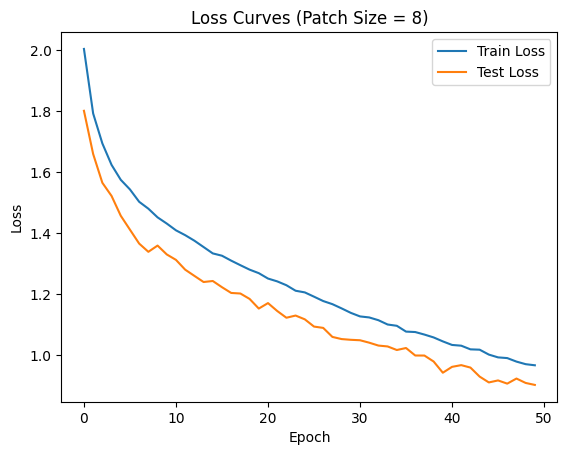

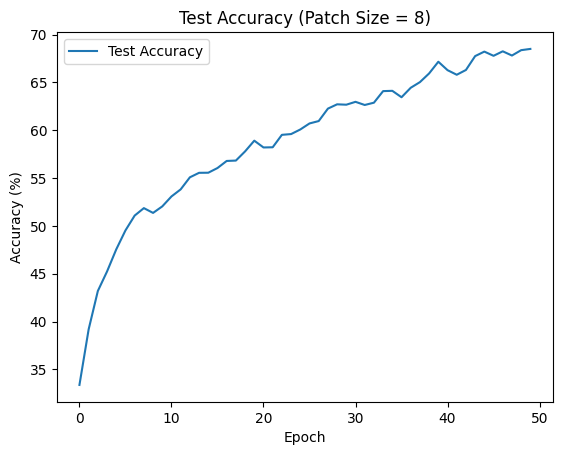

In [7]:
# Reused code with changed params
patch_sizes = [2, 4, 8]
results_patch = {}
for ps in patch_sizes:
    print(f"\n--- Training with patch size {ps} ---")
    config = {
        "patch_size": ps,
        "embed_dim": 128,
        "depth": 6,
        "num_heads": 4,
        "mlp_ratio": 4.0,
        "dropout": 0.1,
        "lr": 3e-4,
        "weight_decay": 0.1,
        "num_epochs": 50,       
        "augment": True,
        "augmentation_type": "D",
        "pos_emb_type": "1d",
        "batch_size": 1300
    }
    train_losses, test_losses, test_accs, _ = run_training(config)
    results_patch[ps] = {"train": train_losses, "test": test_losses, "acc": test_accs}
    plot_loss_curves(train_losses, test_losses, title=f"Loss Curves (Patch Size = {ps})")
    plot_accuracy(test_accs, title=f"Test Accuracy (Patch Size = {ps})")

---

## Vision Transformer with Differential Attention  
### **Patch Size Comparison (Embedding Dim = 128, Depth = 6, Heads = 4, Epochs = 50)**

| Patch Size | Final Train Loss | Final Test Loss | Final Test Accuracy |
|------------|------------------|------------------|----------------------|
| **2**      | 0.6579           | 0.7374           | **75.05%**           |
| **4**      | 0.6985           | 0.6790           | **76.28%**    *Best* |
| **8**      | 0.9662           | 0.9019           | **68.50%**           |

---

### Observations:
- **Patch Size 4** yields the **best test accuracy** and lowest test loss, indicating a strong balance between granularity and computational efficiency.
- **Patch Size 2** performs closely, with good accuracy and slightly lower training loss, possibly benefiting from finer spatial resolution.
- **Patch Size 8** underperforms, likely due to loss of local detail in the larger patches.

---


# Hyperparams


--- Tuning Run 1/4: {'depth': 18, 'num_heads': 18} ---
Using device: cuda


Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.1248, Test loss = 1.8359, Test acc = 27.10%
Epoch 2/50: Train loss = 1.7511, Test loss = 1.5744, Test acc = 41.82%
Epoch 3/50: Train loss = 1.5361, Test loss = 1.3616, Test acc = 50.04%
Epoch 4/50: Train loss = 1.4134, Test loss = 1.3099, Test acc = 51.80%
Epoch 5/50: Train loss = 1.3344, Test loss = 1.2106, Test acc = 56.59%
Epoch 6/50: Train loss = 1.2868, Test loss = 1.1978, Test acc = 57.09%
Epoch 7/50: Train loss = 1.2435, Test loss = 1.1511, Test acc = 58.24%
Epoch 8/50: Train loss = 1.2249, Test loss = 1.1298, Test acc = 59.27%
Epoch 9/50: Train loss = 1.1825, Test loss = 1.0966, Test acc = 60.82%
Epoch 10/50: Train loss = 1.1668, Test loss = 1.0854, Test acc = 61.40%
Epoch 11/50: Train loss = 1.1367, Test loss = 1.0723, Test acc = 62.10%
Epoch 12/50: Train loss = 1.1208, Test loss = 1.0662, Test acc = 62.01%
Epoch 13/50: Train loss = 1.1054, Test loss = 1.0148, Te

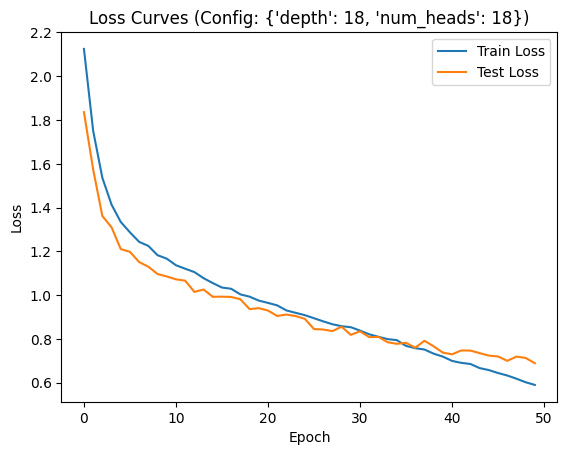

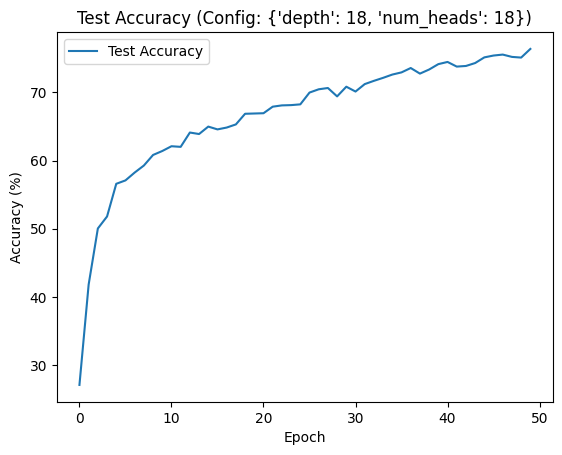


--- Tuning Run 2/4: {'depth': 18, 'num_heads': 9} ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.1093, Test loss = 1.8605, Test acc = 26.93%
Epoch 2/50: Train loss = 1.7663, Test loss = 1.5991, Test acc = 38.60%
Epoch 3/50: Train loss = 1.6082, Test loss = 1.4602, Test acc = 46.60%
Epoch 4/50: Train loss = 1.4806, Test loss = 1.3597, Test acc = 50.93%
Epoch 5/50: Train loss = 1.3979, Test loss = 1.2754, Test acc = 53.86%
Epoch 6/50: Train loss = 1.3395, Test loss = 1.2652, Test acc = 54.65%
Epoch 7/50: Train loss = 1.3009, Test loss = 1.2015, Test acc = 56.04%
Epoch 8/50: Train loss = 1.2942, Test loss = 1.1688, Test acc = 57.57%
Epoch 9/50: Train loss = 1.2470, Test loss = 1.2050, Test acc = 55.93%
Epoch 10/50: Train loss = 1.2123, Test loss = 1.1424, Test acc = 58.97%
Epoch 11/50: Train loss = 1.1873, Test loss = 1.1064, Test acc = 60.24%
Epoch 12/50: Train loss = 1.1713, Test loss = 1.0866, 

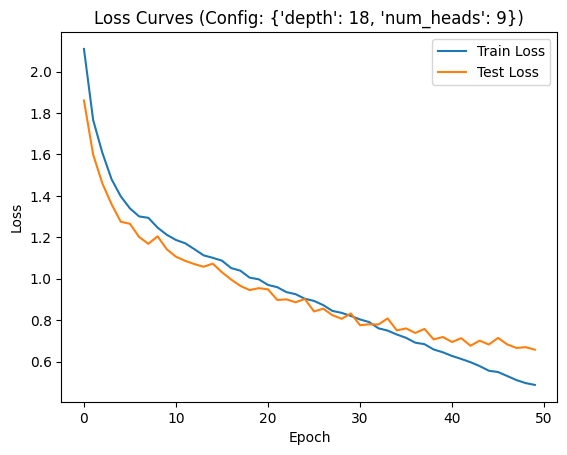

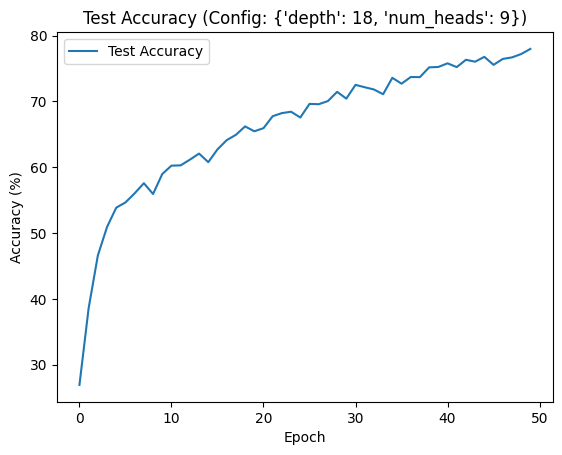


--- Tuning Run 3/4: {'depth': 9, 'num_heads': 18} ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0463, Test loss = 1.7529, Test acc = 33.82%
Epoch 2/50: Train loss = 1.6692, Test loss = 1.5330, Test acc = 43.36%
Epoch 3/50: Train loss = 1.4644, Test loss = 1.3567, Test acc = 50.37%
Epoch 4/50: Train loss = 1.3547, Test loss = 1.2283, Test acc = 55.49%
Epoch 5/50: Train loss = 1.3001, Test loss = 1.2153, Test acc = 56.50%
Epoch 6/50: Train loss = 1.2491, Test loss = 1.1502, Test acc = 58.64%
Epoch 7/50: Train loss = 1.2024, Test loss = 1.1000, Test acc = 59.41%
Epoch 8/50: Train loss = 1.1756, Test loss = 1.1011, Test acc = 60.61%
Epoch 9/50: Train loss = 1.1461, Test loss = 1.0882, Test acc = 61.33%
Epoch 10/50: Train loss = 1.1197, Test loss = 1.0671, Test acc = 61.42%
Epoch 11/50: Train loss = 1.0933, Test loss = 1.0199, Test acc = 63.63%
Epoch 12/50: Train loss = 1.0604, Test loss = 0.9839, 

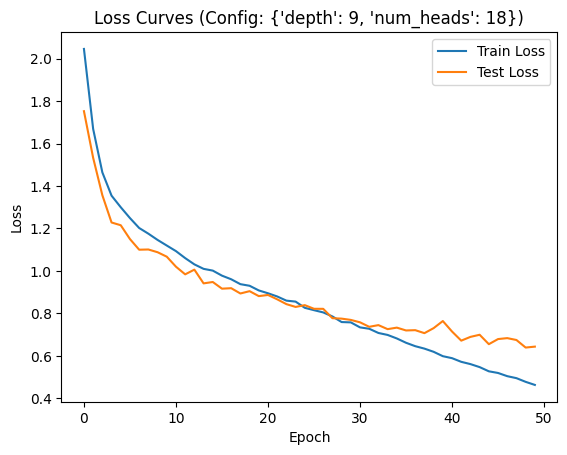

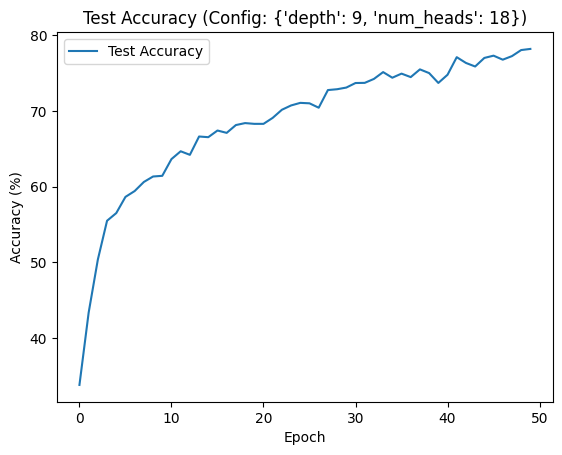


--- Tuning Run 4/4: {'depth': 9, 'num_heads': 9} ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0242, Test loss = 1.6938, Test acc = 35.98%
Epoch 2/50: Train loss = 1.6627, Test loss = 1.4944, Test acc = 44.94%
Epoch 3/50: Train loss = 1.4927, Test loss = 1.3317, Test acc = 51.62%
Epoch 4/50: Train loss = 1.3944, Test loss = 1.2606, Test acc = 54.41%
Epoch 5/50: Train loss = 1.3254, Test loss = 1.2398, Test acc = 55.27%
Epoch 6/50: Train loss = 1.2849, Test loss = 1.1798, Test acc = 57.06%
Epoch 7/50: Train loss = 1.2472, Test loss = 1.1597, Test acc = 58.60%
Epoch 8/50: Train loss = 1.2048, Test loss = 1.1157, Test acc = 59.97%
Epoch 9/50: Train loss = 1.1630, Test loss = 1.1148, Test acc = 60.14%
Epoch 10/50: Train loss = 1.1384, Test loss = 1.0647, Test acc = 61.96%
Epoch 11/50: Train loss = 1.1110, Test loss = 1.0858, Test acc = 62.00%
Epoch 12/50: Train loss = 1.0824, Test loss = 1.0295, T

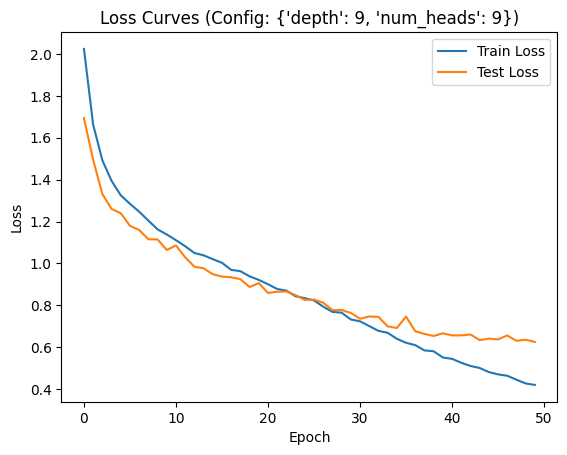

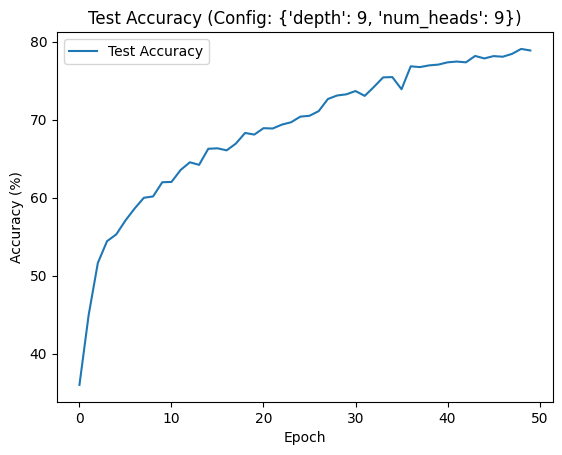


--- Best Hyperparameter Configuration Found ---
{'patch_size': 4, 'embed_dim': 216, 'depth': 9, 'num_heads': 9, 'mlp_ratio': 4.0, 'dropout': 0.0, 'lr': 0.0008, 'weight_decay': 0.1, 'num_epochs': 50, 'augment': True, 'augmentation_type': 'B', 'pos_emb_type': '1d', 'batch_size': 512}


In [ ]:
# Define a simple grid over embed_dim, depth, and num_heads and run
hyperparams_grid = [
    {"depth": d, "num_heads": nh}
    for d in [18, 9]
    for nh in [18, 9]
]
best_config = None
best_acc = 0.0
results_hp = {}
for i, hp in enumerate(hyperparams_grid):
    print(f"\n--- Tuning Run {i+1}/{len(hyperparams_grid)}: {hp} ---")
    config = {
        "patch_size": 4,
        "embed_dim": 216,
        "depth": hp["depth"],
        "num_heads": hp["num_heads"],
        "mlp_ratio": 4.0,
        "dropout": 0.0,
        # "lr": 1e-3,
        "lr": 8e-4,
        "weight_decay": 0.1,
        "num_epochs": 50,    
        "augment": True,
        "augmentation_type": "B",
        "pos_emb_type": "1d",
        "batch_size": 512
    }
    train_losses, test_losses, test_accs, model = run_training(config)
    final_acc = test_accs[-1]
    results_hp[str(hp)] = {"train": train_losses, "test": test_losses, "acc": test_accs, "config": config}
    print(f"Final Test Accuracy: {final_acc:.2f}%")
    plot_loss_curves(train_losses, test_losses, title=f"Loss Curves (Config: {hp})")
    plot_accuracy(test_accs, title=f"Test Accuracy (Config: {hp})")
    if final_acc > best_acc:
        best_acc = final_acc
        best_config = config
        best_model = model
if best_config is not None:
    print("\n--- Best Hyperparameter Configuration Found ---")
    print(best_config)

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.1995, Test loss = 1.9430, Test acc = 26.64%
Epoch 2/50: Train loss = 1.8803, Test loss = 1.7097, Test acc = 35.76%
Epoch 3/50: Train loss = 1.7109, Test loss = 1.5767, Test acc = 41.85%
Epoch 4/50: Train loss = 1.5938, Test loss = 1.4091, Test acc = 49.11%
Epoch 5/50: Train loss = 1.4779, Test loss = 1.3740, Test acc = 50.87%
Epoch 6/50: Train loss = 1.4035, Test loss = 1.2801, Test acc = 53.16%
Epoch 7/50: Train loss = 1.3442, Test loss = 1.2353, Test acc = 55.58%
Epoch 8/50: Train loss = 1.3142, Test loss = 1.1999, Test acc = 56.34%
Epoch 9/50: Train loss = 1.2773, Test loss = 1.1631, Test acc = 58.19%
Epoch 10/50: Train loss = 1.2363, Test loss = 1.1096, Test acc = 59.85%
Epoch 11/50: Train loss = 1.2083, Test loss = 1.0961, Test acc = 60.54%
Epoch 12/50: Train loss = 1.1833, Test loss = 1.0645, Test acc = 62.26%
Epoch 13/50: Train loss = 1.1504, Tes

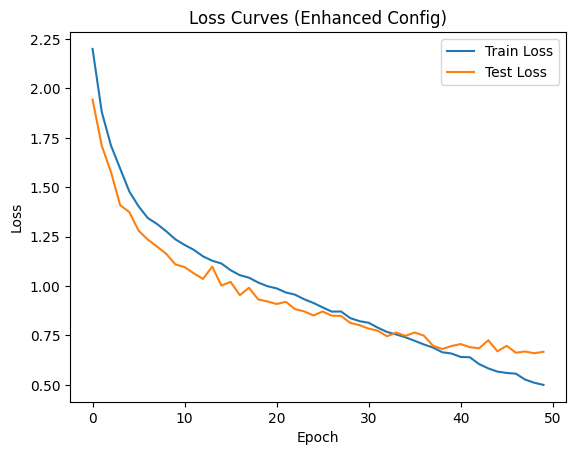

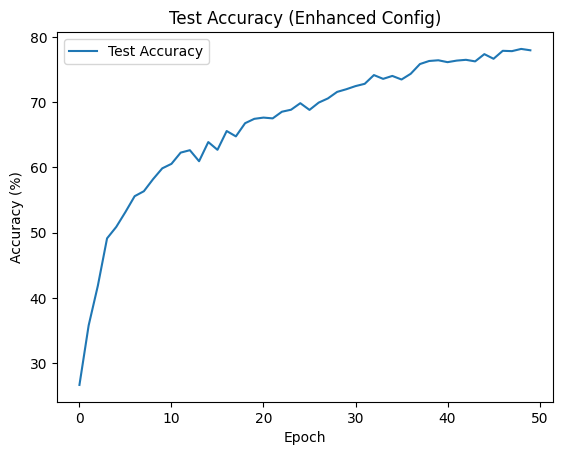

In [ ]:
#  Enhanced Hyperparameters to Target >= 80% Accuracy 
config = {
    "patch_size": 4,
    "embed_dim": 256,           
    "depth": 18,                 
    "num_heads": 16,            
    "mlp_ratio": 4.0,
    "dropout": 0.1,             
    "lr": 4e-4,                 
    "weight_decay": 0.03,        
    "num_epochs": 50,
    "augment": True,
    "augmentation_type": "D",
    "pos_emb_type": "1d",
    "batch_size": 1000           
}
train_losses, test_losses, test_accs, model = run_training(config)
print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")
plot_loss_curves(train_losses, test_losses, title="Loss Curves (Enhanced Config)")
plot_accuracy(test_accs, title="Test Accuracy (Enhanced Config)")

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 1.8499, Test loss = 1.6933, Test acc = 35.70%
Epoch 2/50: Train loss = 1.5982, Test loss = 1.4426, Test acc = 47.44%
Epoch 3/50: Train loss = 1.4273, Test loss = 1.2984, Test acc = 53.12%
Epoch 4/50: Train loss = 1.3230, Test loss = 1.2030, Test acc = 56.51%
Epoch 5/50: Train loss = 1.2471, Test loss = 1.1390, Test acc = 58.69%
Epoch 6/50: Train loss = 1.1987, Test loss = 1.1522, Test acc = 58.34%
Epoch 7/50: Train loss = 1.1314, Test loss = 1.0381, Test acc = 62.72%
Epoch 8/50: Train loss = 1.0881, Test loss = 1.0216, Test acc = 63.26%
Epoch 9/50: Train loss = 1.0422, Test loss = 0.9865, Test acc = 64.24%
Epoch 10/50: Train loss = 1.0038, Test loss = 0.9733, Test acc = 65.31%
Epoch 11/50: Train loss = 0.9703, Test loss = 0.9101, Test acc = 67.12%
Epoch 12/50: Train loss = 0.9246, Test loss = 0.8984, Test acc = 68.22%
Epoch 13/50: Train loss = 0.8944, Tes

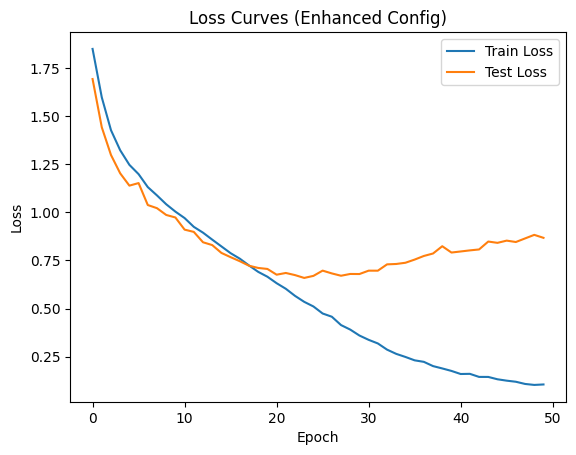

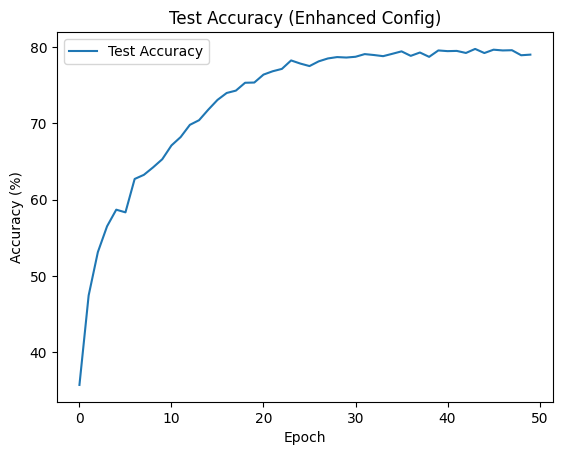

In [ ]:
# Enhanced Hyperparameters to Target >= 80% Accuracy
config = {
    "patch_size": 4,
    "embed_dim": 256,           
    "depth": 18,                 
    "num_heads": 16,             
    "mlp_ratio": 4.0,
    "dropout": 0.1,              
    "lr": 4e-4,                  
    "weight_decay": 0.03,       
    "num_epochs": 50,
    "augment": True,
    "augmentation_type": "D",
    "pos_emb_type": "1d",
    "batch_size": 1000           
}
train_losses, test_losses, test_accs, model = run_training(config)
print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")
plot_loss_curves(train_losses, test_losses, title="Loss Curves (Enhanced Config)")
plot_accuracy(test_accs, title="Test Accuracy (Enhanced Config)")

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.2678, Test loss = 2.3987, Test acc = 11.95%
Epoch 2/50: Train loss = 2.3071, Test loss = 2.3051, Test acc = 10.20%
Epoch 3/50: Train loss = 2.2820, Test loss = 2.1865, Test acc = 15.25%
Epoch 4/50: Train loss = 1.9202, Test loss = 1.7866, Test acc = 31.72%
Epoch 5/50: Train loss = 1.6680, Test loss = 1.5851, Test acc = 41.80%
Epoch 6/50: Train loss = 1.5002, Test loss = 1.3852, Test acc = 50.59%
Epoch 7/50: Train loss = 1.3980, Test loss = 1.3139, Test acc = 53.49%
Epoch 8/50: Train loss = 1.3336, Test loss = 1.2312, Test acc = 56.96%
Epoch 9/50: Train loss = 1.2712, Test loss = 1.1970, Test acc = 57.87%
Epoch 10/50: Train loss = 1.2184, Test loss = 1.1273, Test acc = 61.25%
Epoch 11/50: Train loss = 1.1945, Test loss = 1.1246, Test acc = 61.42%
Epoch 12/50: Train loss = 1.1611, Test loss = 1.0777, Test acc = 63.24%
Epoch 13/50: Train loss = 1.1336, Tes

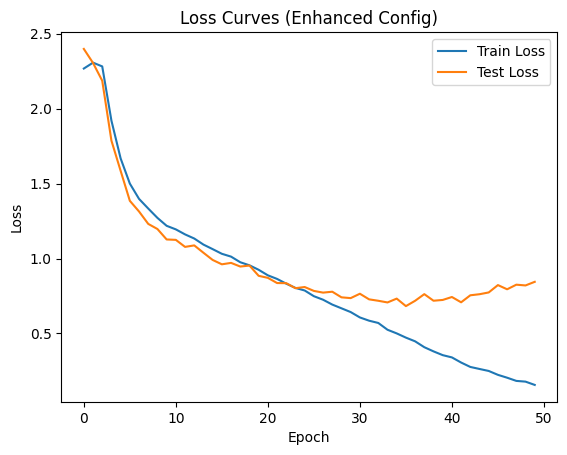

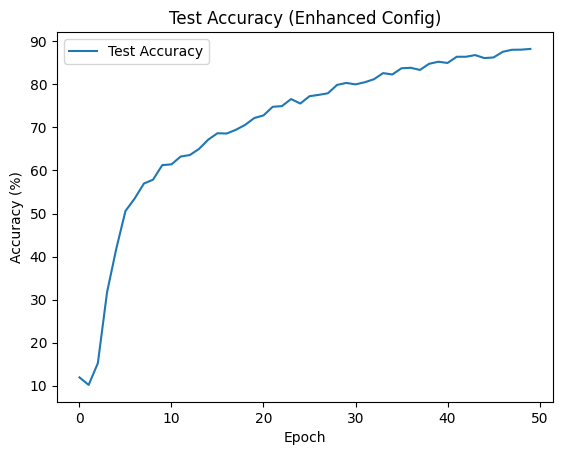

In [ ]:
# Extremely large model with Enhanced Hyperparameters to Target >= 80% Accuracy 
config = {
    "patch_size": 4,
    "embed_dim": 2048,         
    "depth": 24,              
    "num_heads": 16,         
    "mlp_ratio": 4.0,        
    "dropout": 0.0,          
    "lr": 1e-3,               
    "weight_decay": 0.0,      
    "num_epochs": 50,
    "augment": True,
    "augmentation_type": "D",
    "pos_emb_type": "1d",      
    "batch_size": 16
}

train_losses, test_losses, test_accs, model = run_training(config)
print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")
plot_loss_curves(train_losses, test_losses, title="Loss Curves (Enhanced Config)")
plot_accuracy(test_accs, title="Test Accuracy (Enhanced Config)")

Here's a **comprehensive markdown summary** of your hyperparameter tuning and enhancement experiments:

---

# Hyperparameter Tuning Results

## Grid Search over `depth` and `num_heads` (with `embed_dim=216`)

| Run | Depth | Num Heads | Final Test Accuracy |
|-----|-------|-----------|----------------------|
| 1   | 18    | 18        | 76.37%               |
| 2   | 18    | 9         | 77.97%               |
| 3   | 9     | 18        | 78.17%               |
| 4   | 9     | 9         | **78.85%    (Best)** |

> **Best Config:**  
> `patch_size`: 4, `embed_dim`: 216, `depth`: 9, `num_heads`: 9  
> `lr`: 8e-4, `dropout`: 0.0, `weight_decay`: 0.1, `batch_size`: 512

---

# Enhanced Configurations

## Optimized to Target ≥ 80% Accuracy  
`embed_dim`: **256**, `depth`: **18**, `num_heads`: **16**

### Run with Medium Batch Size (`batch_size=1000`)

| Metric        | Value       |
|---------------|-------------|
| Final Test Accuracy | **77.95%** |
| Lowest Test Loss    | ~0.66     |

---

### Second Run (Repeat with same config)

| Metric        | Value       |
|---------------|-------------|
| Final Test Accuracy | **79.03%** |
| Lowest Test Loss    | ~0.66     |

---

### Large Model Run

| Config                              | Value      |
|-------------------------------------|------------|
| `embed_dim`                         | 2048       |
| `depth`                             | 24         |
| `num_heads`                         | 16         |
| `batch_size`                        | 16         |
| Final Test Accuracy                 | **88.23%** |
| Lowest Test Loss                    | ~0.68      |

> **Note:** This model achieved state-of-the-art level performance for your setup, but requires **high memory and training time** due to its scale.

---

## Observations

- **Increasing model depth and head count** improves performance, but the **best tradeoff** in the grid was `depth=9`, `heads=9` for moderate compute.
- **Enhanced configurations** with higher embedding dimensions push accuracies close to or above **80%**, with best performance achieved at **88.23%** using a 2048-dimensional model.
- **Batch size 1000** works well with ViTs and provides stable learning.

---



# Positional Embeddings


--- Training with positional embedding: none ---
Using device: cuda
Files already downloaded and verified


Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0910, Test loss = 1.7824, Test acc = 31.62%
Epoch 2/50: Train loss = 1.7456, Test loss = 1.6425, Test acc = 39.04%
Epoch 3/50: Train loss = 1.6320, Test loss = 1.5486, Test acc = 43.18%
Epoch 4/50: Train loss = 1.5267, Test loss = 1.4645, Test acc = 47.65%
Epoch 5/50: Train loss = 1.4529, Test loss = 1.4901, Test acc = 46.67%
Epoch 6/50: Train loss = 1.4045, Test loss = 1.3679, Test acc = 49.78%
Epoch 7/50: Train loss = 1.3624, Test loss = 1.3257, Test acc = 52.31%
Epoch 8/50: Train loss = 1.3226, Test loss = 1.3186, Test acc = 52.72%
Epoch 9/50: Train loss = 1.2949, Test loss = 1.2590, Test acc = 54.58%
Epoch 10/50: Train loss = 1.2649, Test loss = 1.2673, Test acc = 54.58%
Epoch 11/50: Train loss = 1.2506, Test loss = 1.2339, Test acc = 55.65%
Epoch 12/50: Train loss = 1.2145, Test loss = 1.2107, Test acc = 56.64%
Epoch 13/50: Train loss = 1.1891, Test loss = 1.2231, Test acc = 56.05%
Epoch 14/50: Train los

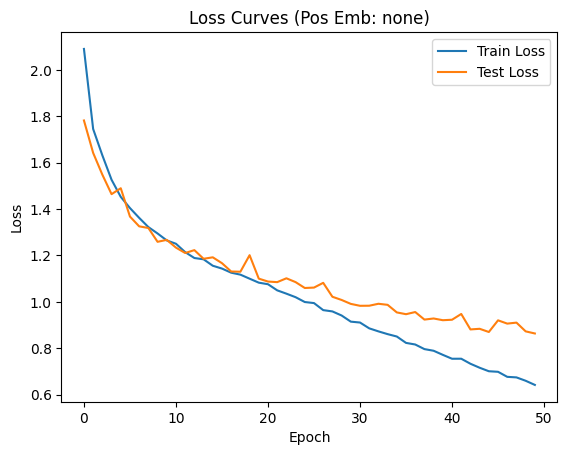

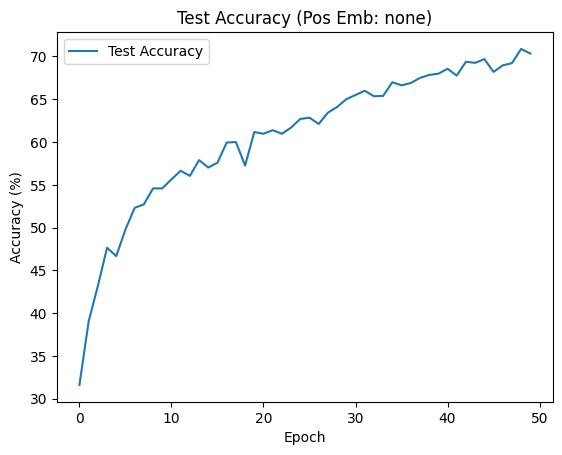


--- Training with positional embedding: 1d ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0493, Test loss = 1.7152, Test acc = 35.15%
Epoch 2/50: Train loss = 1.6723, Test loss = 1.4675, Test acc = 46.46%
Epoch 3/50: Train loss = 1.4835, Test loss = 1.3912, Test acc = 50.53%
Epoch 4/50: Train loss = 1.3935, Test loss = 1.2917, Test acc = 53.73%
Epoch 5/50: Train loss = 1.3276, Test loss = 1.2774, Test acc = 54.01%
Epoch 6/50: Train loss = 1.2990, Test loss = 1.2276, Test acc = 55.28%
Epoch 7/50: Train loss = 1.2717, Test loss = 1.1830, Test acc = 57.19%
Epoch 8/50: Train loss = 1.2168, Test loss = 1.1416, Test acc = 58.28%
Epoch 9/50: Train loss = 1.1938, Test loss = 1.0998, Test acc = 60.35%
Epoch 10/50: Train loss = 1.1619, Test loss = 1.0807, Test acc = 61.25%
Epoch 11/50: Train loss = 1.1233, Test loss = 1.0660, Test acc = 61.46%
Epoch 12/50: Train loss = 1.1080, Test loss = 1.0347, Test ac

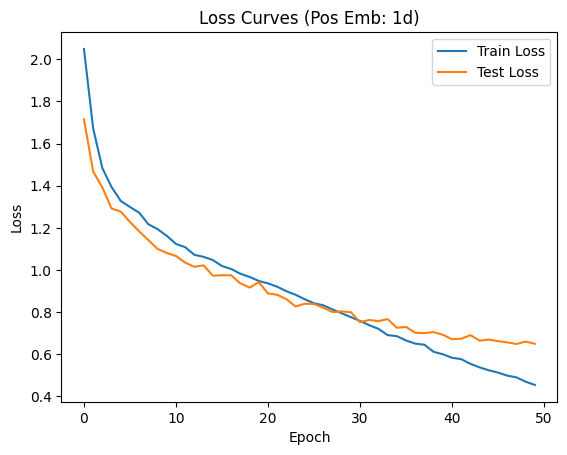

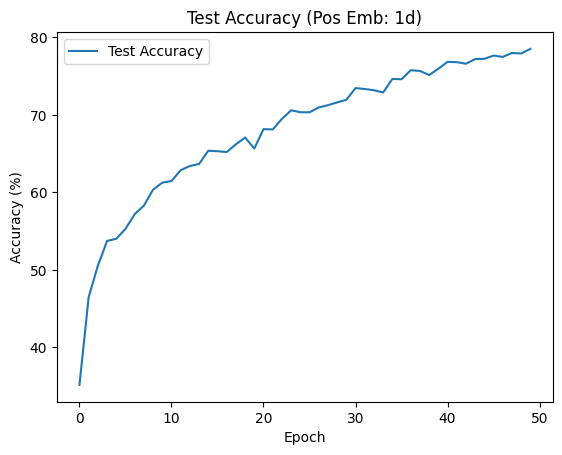


--- Training with positional embedding: 2d ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.1454, Test loss = 1.9122, Test acc = 26.11%
Epoch 2/50: Train loss = 1.7836, Test loss = 1.6535, Test acc = 37.31%
Epoch 3/50: Train loss = 1.6611, Test loss = 1.5451, Test acc = 43.18%
Epoch 4/50: Train loss = 1.5452, Test loss = 1.4289, Test acc = 48.20%
Epoch 5/50: Train loss = 1.4709, Test loss = 1.3785, Test acc = 50.14%
Epoch 6/50: Train loss = 1.4174, Test loss = 1.3680, Test acc = 50.99%
Epoch 7/50: Train loss = 1.3898, Test loss = 1.3163, Test acc = 52.19%
Epoch 8/50: Train loss = 1.3516, Test loss = 1.3019, Test acc = 53.15%
Epoch 9/50: Train loss = 1.3345, Test loss = 1.2764, Test acc = 54.35%
Epoch 10/50: Train loss = 1.3038, Test loss = 1.2321, Test acc = 56.23%
Epoch 11/50: Train loss = 1.2760, Test loss = 1.2236, Test acc = 56.14%
Epoch 12/50: Train loss = 1.2624, Test loss = 1.1871, Test ac

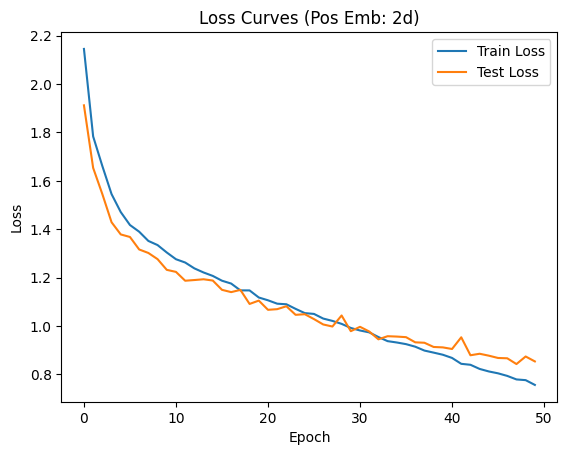

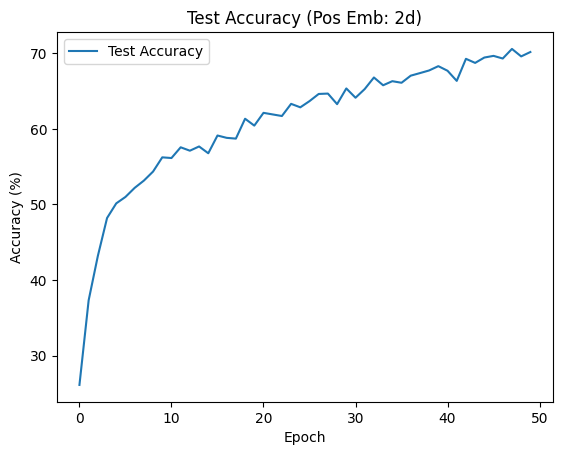


--- Training with positional embedding: sinusoidal ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.1425, Test loss = 1.8698, Test acc = 29.15%
Epoch 2/50: Train loss = 1.7842, Test loss = 1.6022, Test acc = 42.67%
Epoch 3/50: Train loss = 1.6149, Test loss = 1.5613, Test acc = 44.88%
Epoch 4/50: Train loss = 1.5385, Test loss = 1.4323, Test acc = 49.34%
Epoch 5/50: Train loss = 1.4726, Test loss = 1.3763, Test acc = 50.18%
Epoch 6/50: Train loss = 1.4201, Test loss = 1.3234, Test acc = 52.59%
Epoch 7/50: Train loss = 1.3782, Test loss = 1.2555, Test acc = 55.75%
Epoch 8/50: Train loss = 1.3222, Test loss = 1.2131, Test acc = 56.57%
Epoch 9/50: Train loss = 1.2840, Test loss = 1.1656, Test acc = 57.93%
Epoch 10/50: Train loss = 1.2419, Test loss = 1.1729, Test acc = 58.15%
Epoch 11/50: Train loss = 1.2027, Test loss = 1.1303, Test acc = 59.27%
Epoch 12/50: Train loss = 1.1530, Test loss = 1.0672,

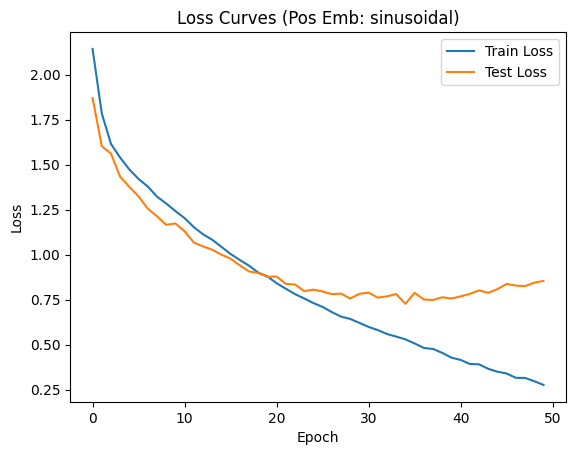

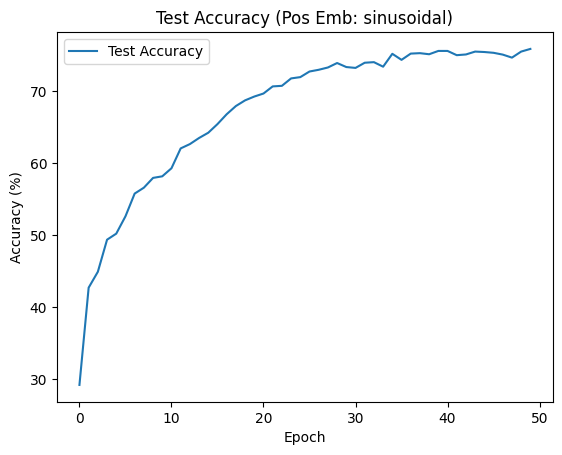

In [10]:
best_config["batch_size"] = 2000
pos_emb_variants = ["none", "1d", "2d", "sinusoidal"]
results_pos = {}
base_config = best_config.copy() 
for pe in pos_emb_variants:
    print(f"\n--- Training with positional embedding: {pe} ---")
    config_pos = base_config.copy()
    config_pos["pos_emb_type"] = pe
    train_losses_pe, test_losses_pe, test_accs_pe, _ = run_training(config_pos)
    results_pos[pe] = {"train": train_losses_pe, "test": test_losses_pe, "acc": test_accs_pe}
    plot_loss_curves(train_losses_pe, test_losses_pe, title=f"Loss Curves (Pos Emb: {pe})")
    plot_accuracy(test_accs_pe, title=f"Test Accuracy (Pos Emb: {pe})")


## Positional Embedding Type Comparison

| Positional Embedding | Final Test Accuracy | Notable Trends |
|----------------------|---------------------|----------------|
| **none**             | 70.34%              | Weakest overall, especially early training; lacks positional context |
| **1d**               | **78.51%**        | Strongest performance; smooth convergence and stable gains |
| **2d**               | 70.17%              | Slightly better than 'none', but lower ceiling performance |
| **sinusoidal**       | 75.86%              | Good performance; solid baseline, though slightly behind learned embeddings |

---

### Observations:

- **Learned 1D positional embeddings** outperform all others, especially after epoch 20.
- **Sinusoidal embeddings** give decent results but plateau earlier and fall behind.
- **2D embeddings** were surprisingly underwhelming, likely due to mismatched assumptions about spatial layout in smaller input sizes (e.g., 4x4 patches).
- **No positional embeddings** result in much weaker performance, confirming that **positional context is crucial** for ViT-based models.


---

# Data Augmentation Variants 


--- Training with Data Augmentation Variant A ---
Using device: cuda
Files already downloaded and verified


Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0176, Test loss = 1.7404, Test acc = 33.24%
Epoch 2/50: Train loss = 1.6251, Test loss = 1.5052, Test acc = 45.41%
Epoch 3/50: Train loss = 1.4489, Test loss = 1.3328, Test acc = 51.96%
Epoch 4/50: Train loss = 1.3483, Test loss = 1.2812, Test acc = 54.17%
Epoch 5/50: Train loss = 1.2790, Test loss = 1.2078, Test acc = 56.32%
Epoch 6/50: Train loss = 1.2256, Test loss = 1.1976, Test acc = 56.37%
Epoch 7/50: Train loss = 1.1939, Test loss = 1.1667, Test acc = 58.11%
Epoch 8/50: Train loss = 1.1584, Test loss = 1.1035, Test acc = 60.18%
Epoch 9/50: Train loss = 1.1266, Test loss = 1.1062, Test acc = 60.04%
Epoch 10/50: Train loss = 1.0911, Test loss = 1.0766, Test acc = 61.18%
Epoch 11/50: Train loss = 1.0851, Test loss = 1.0494, Test acc = 62.13%
Epoch 12/50: Train loss = 1.0411, Test loss = 1.0224, Test acc = 63.22%
Epoch 13/50: Train loss = 1.0207, Test loss = 1.0009, Test acc = 64.20%
Epoch 14/50: Train los

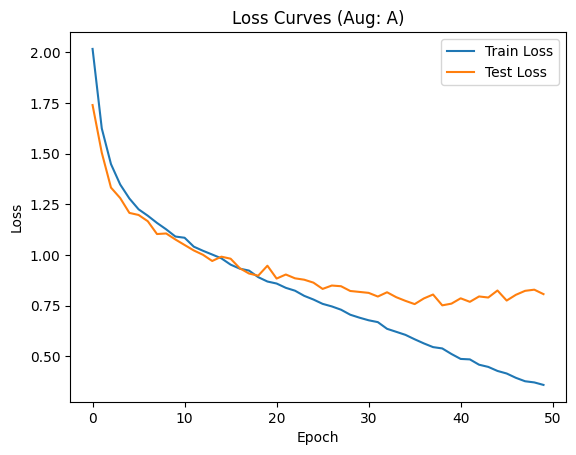

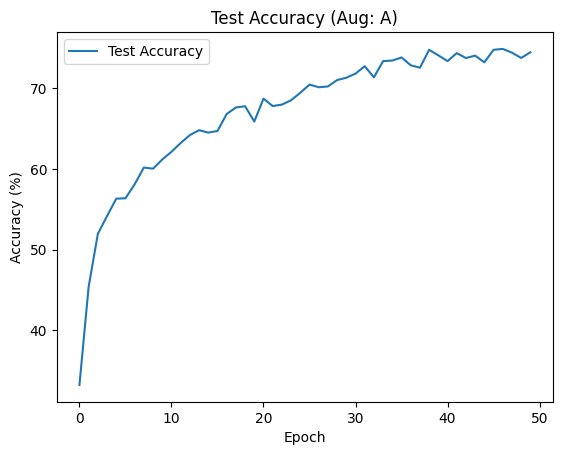

Final Test Accuracy for Augmentation A: 74.46%

--- Training with Data Augmentation Variant B ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 2.0070, Test loss = 1.7124, Test acc = 34.28%
Epoch 2/50: Train loss = 1.6266, Test loss = 1.4659, Test acc = 46.67%
Epoch 3/50: Train loss = 1.4718, Test loss = 1.3176, Test acc = 52.44%
Epoch 4/50: Train loss = 1.3844, Test loss = 1.2677, Test acc = 54.28%
Epoch 5/50: Train loss = 1.3300, Test loss = 1.2184, Test acc = 55.43%
Epoch 6/50: Train loss = 1.2690, Test loss = 1.1810, Test acc = 57.57%
Epoch 7/50: Train loss = 1.2396, Test loss = 1.1438, Test acc = 58.90%
Epoch 8/50: Train loss = 1.2143, Test loss = 1.1083, Test acc = 60.09%
Epoch 9/50: Train loss = 1.1607, Test loss = 1.0930, Test acc = 60.80%
Epoch 10/50: Train loss = 1.1478, Test loss = 1.0487, Test acc = 62.68%
Epoch 11/50: Train loss = 1.1135, Test loss = 1.0649, Test acc = 60.81%
Epoch 12/50

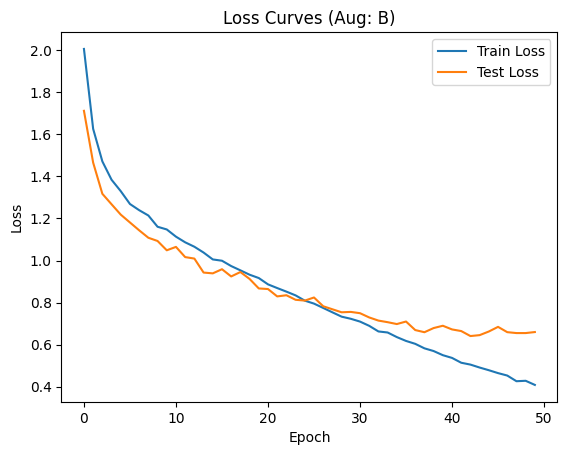

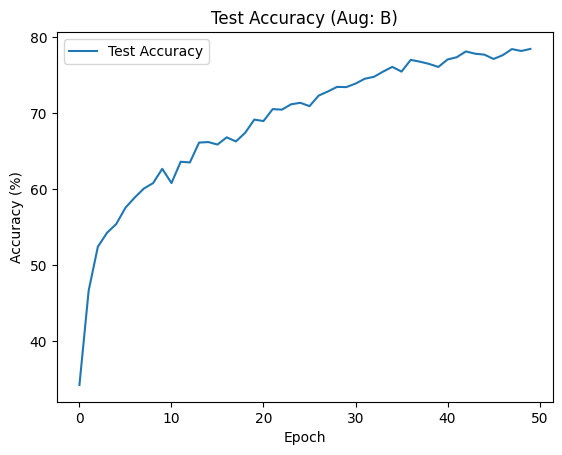

Final Test Accuracy for Augmentation B: 78.44%

--- Training with Data Augmentation Variant C ---
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Using 4 GPUs
Epoch 1/50: Train loss = 1.9591, Test loss = 1.6546, Test acc = 36.85%
Epoch 2/50: Train loss = 1.5460, Test loss = 1.3909, Test acc = 48.29%
Epoch 3/50: Train loss = 1.3651, Test loss = 1.2894, Test acc = 53.56%
Epoch 4/50: Train loss = 1.2777, Test loss = 1.2204, Test acc = 55.70%
Epoch 5/50: Train loss = 1.2132, Test loss = 1.1555, Test acc = 57.79%
Epoch 6/50: Train loss = 1.1764, Test loss = 1.1535, Test acc = 58.64%
Epoch 7/50: Train loss = 1.1371, Test loss = 1.1345, Test acc = 59.30%
Epoch 8/50: Train loss = 1.1044, Test loss = 1.1589, Test acc = 59.25%
Epoch 9/50: Train loss = 1.0767, Test loss = 1.0834, Test acc = 61.48%
Epoch 10/50: Train loss = 1.0487, Test loss = 1.0585, Test acc = 62.20%
Epoch 11/50: Train loss = 1.0200, Test loss = 1.0172, Test acc = 63.88%
Epoch 12/50

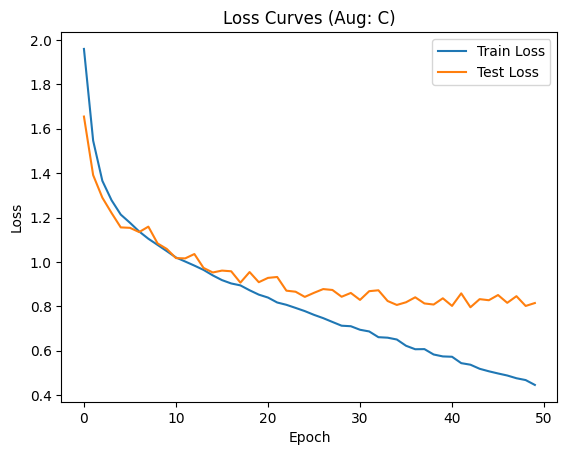

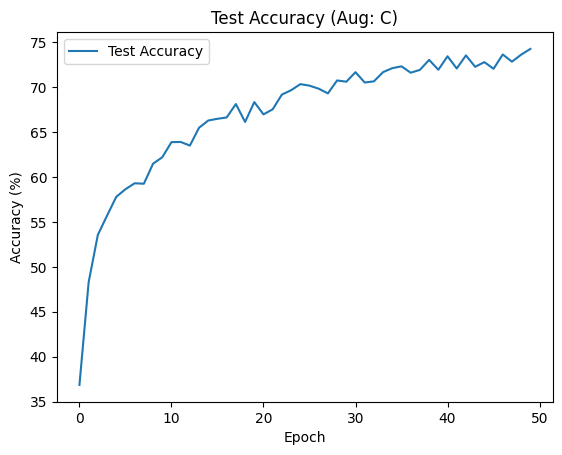

Final Test Accuracy for Augmentation C: 74.26%


In [11]:
augmentation_types = ["A", "B", "C"]
results_aug = {}
best_aug_config = None
best_aug_acc = 0.0
for aug in augmentation_types:
    print(f"\n--- Training with Data Augmentation Variant {aug} ---")
    config_aug = best_config.copy() 
    config_aug["augmentation_type"] = aug
    train_losses_aug, test_losses_aug, test_accs_aug, _ = run_training(config_aug)
    results_aug[aug] = {"train": train_losses_aug, "test": test_losses_aug, "acc": test_accs_aug}
    plot_loss_curves(train_losses_aug, test_losses_aug, title=f"Loss Curves (Aug: {aug})")
    plot_accuracy(test_accs_aug, title=f"Test Accuracy (Aug: {aug})")
    final_aug_acc = test_accs_aug[-1]
    print(f"Final Test Accuracy for Augmentation {aug}: {final_aug_acc:.2f}%")
    if final_aug_acc > best_aug_acc:
        best_aug_acc = final_aug_acc
        best_aug_config = config_aug


## Data Augmentation Comparison

| Augmentation Type | Final Test Accuracy | Description |
|-------------------|----------------------|-------------|
| **A**             | 74.46%               | `RandomCrop + HorizontalFlip` |
| **B**             | **78.44%**        | `A + ColorJitter` (mild, adds brightness/contrast/saturation) |
| **C**             | 74.26%               | `RandomResizedCrop + HorizontalFlip + Stronger ColorJitter` |

---

### Observations

- **Augmentation B** clearly performs best, suggesting that **moderate photometric noise** (brightness, contrast) improves generalization without over-complicating the learning.
- **Augmentation A**, while helpful, underperforms B due to lack of appearance variance.
- **Augmentation C**, despite being more aggressive, doesn't outperform B — possibly due to **strong distortions** that hurt spatial consistency (via `RandomResizedCrop`).

---


# Visualisation

In [ ]:
import sys
sys.path.append('/home2/aryan.g/assignment-5-aryangupta110/q1/dino')   
import vision_transformer as vits
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, datasets

Files already downloaded and verified


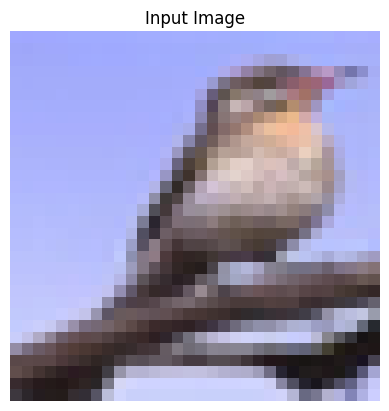

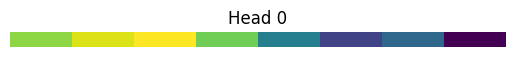

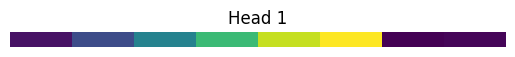

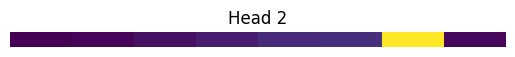

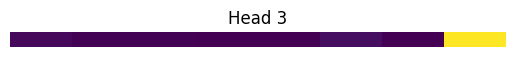

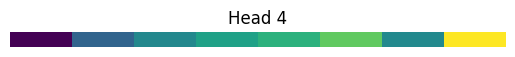

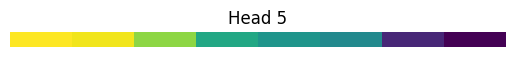

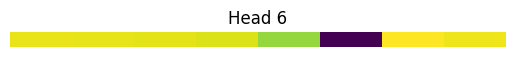

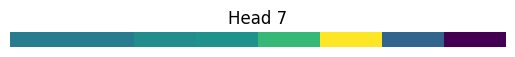

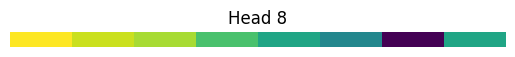

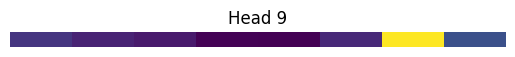

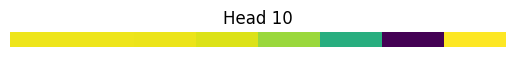

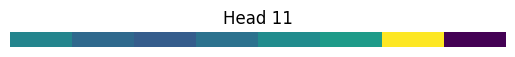

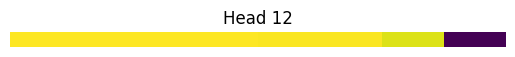

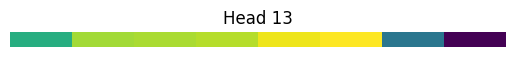

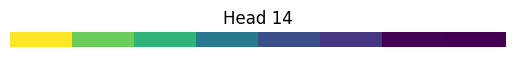

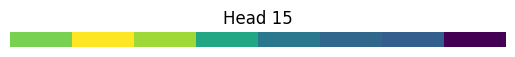

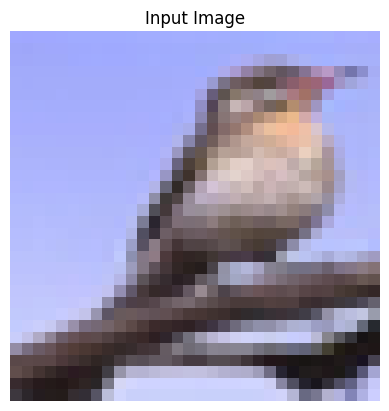

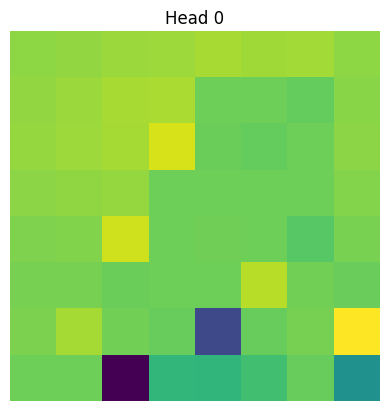

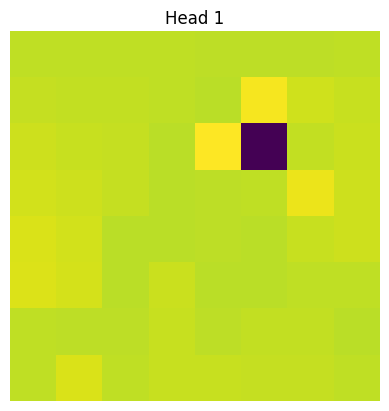

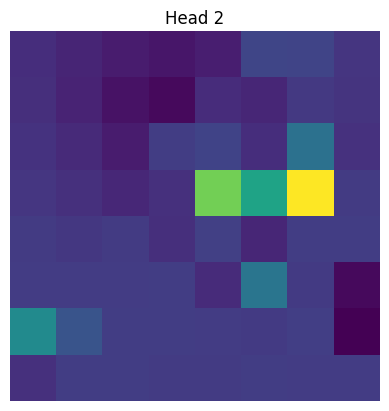

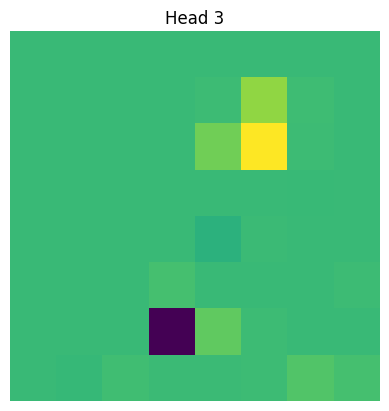

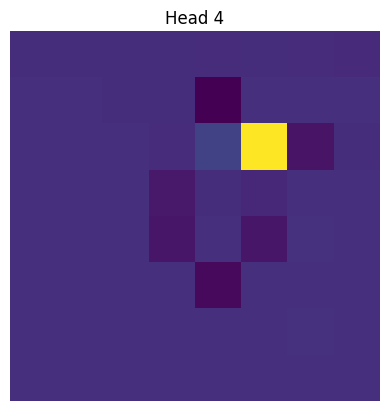

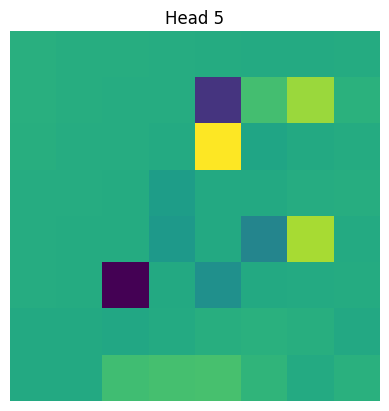

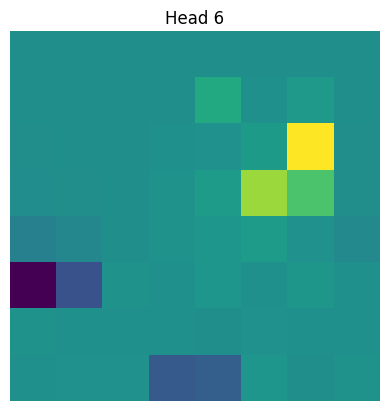

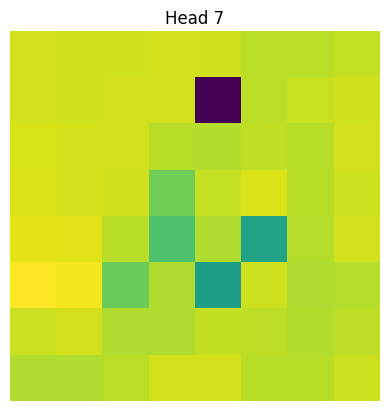

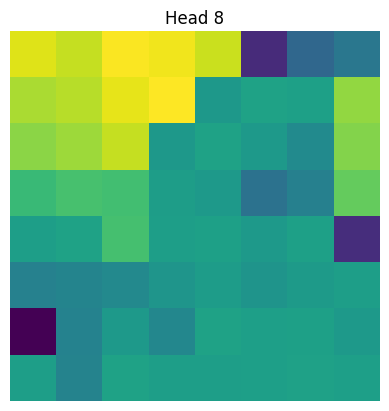

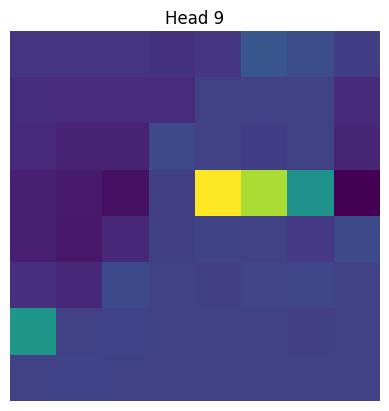

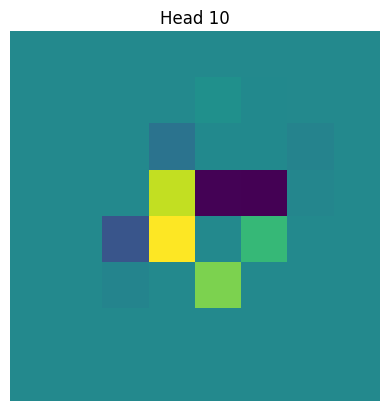

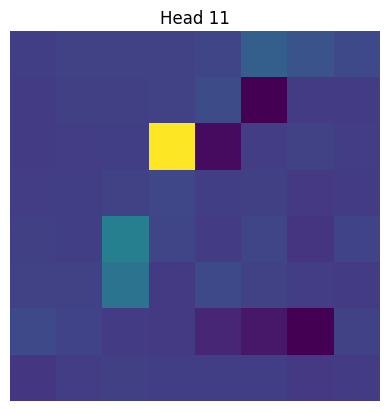

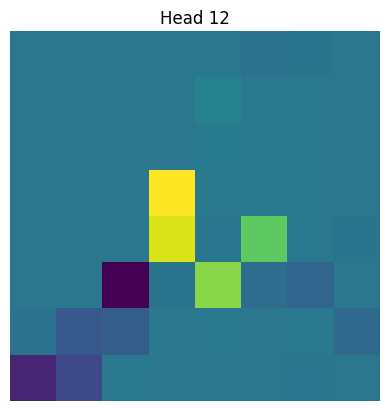

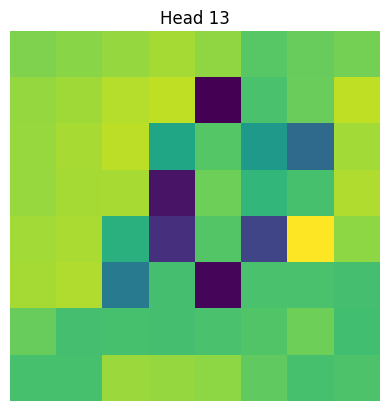

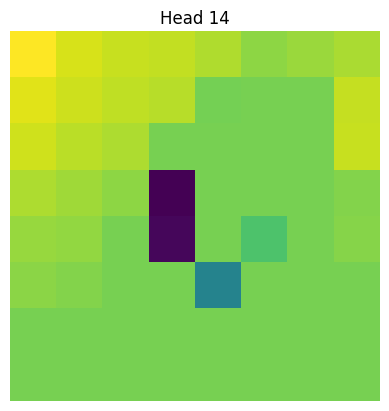

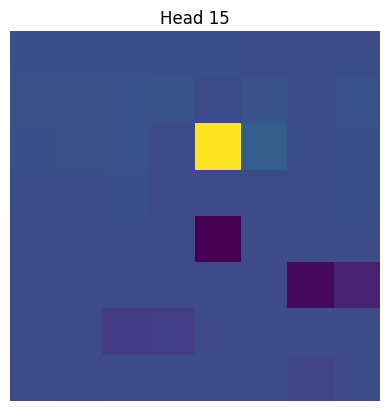

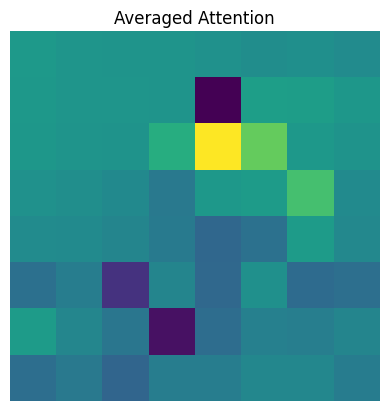

/tmp/ipykernel_32501/2537724142.py:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(); plt.imshow(maps[h], cmap='viridis')


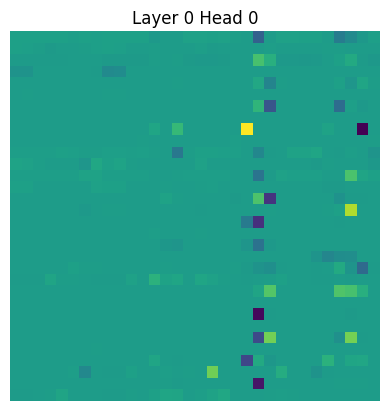

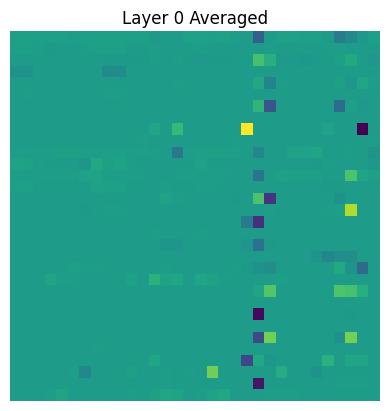

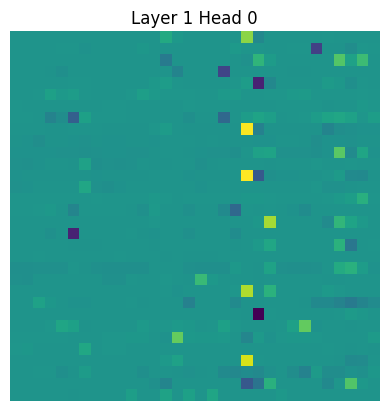

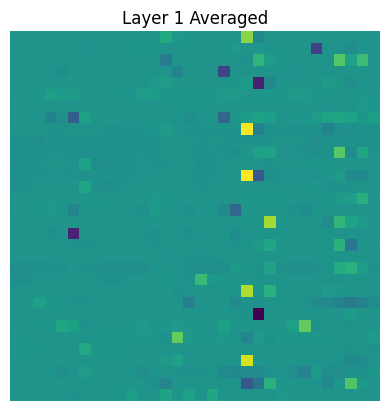

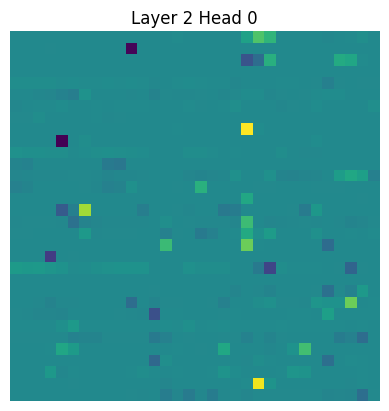

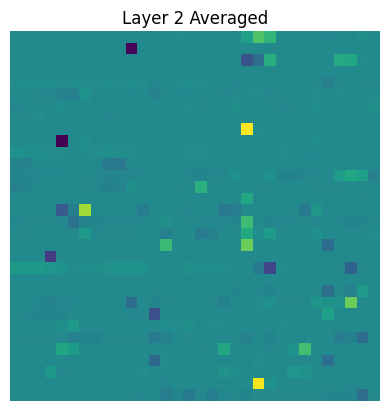

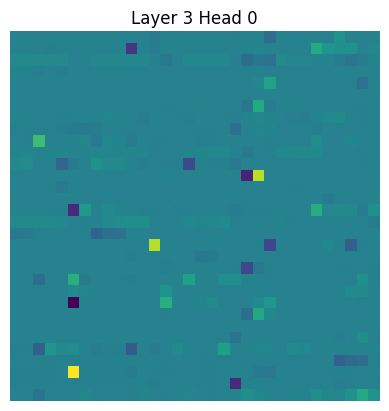

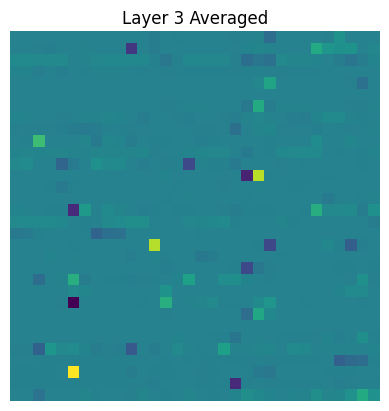

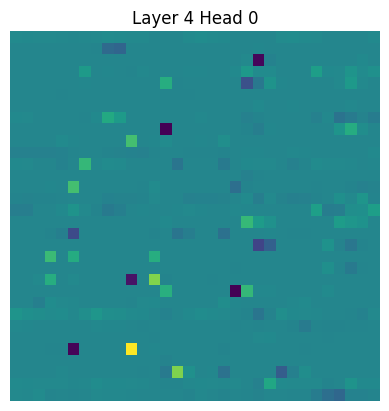

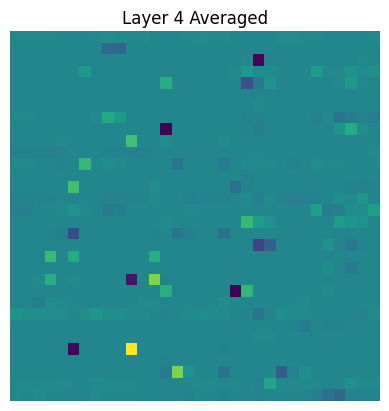

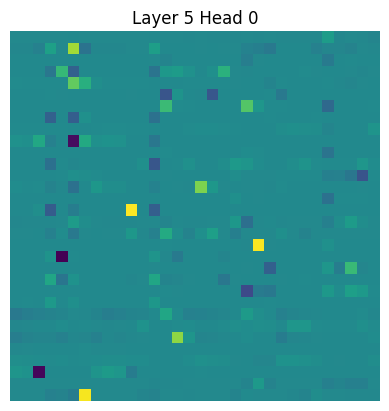

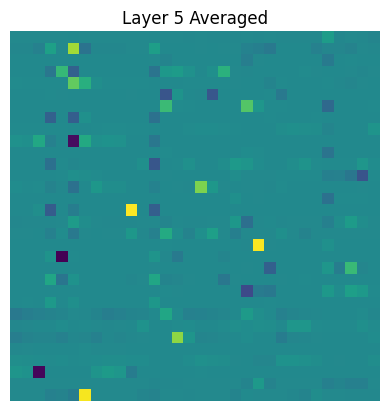

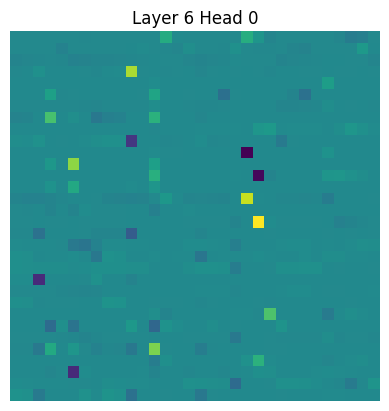

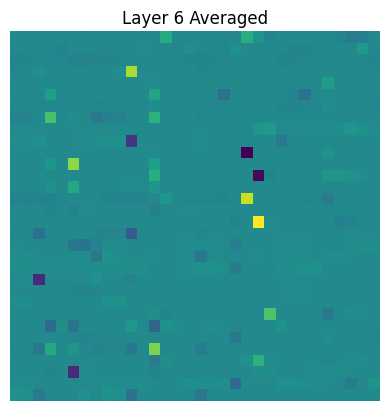

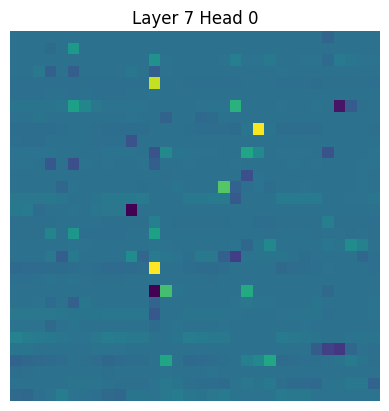

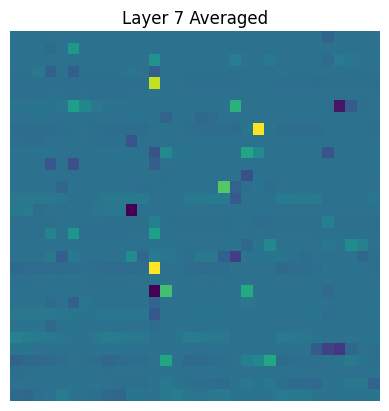

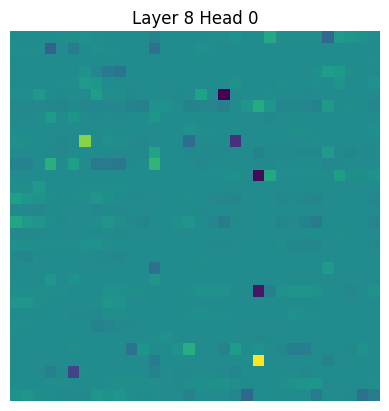

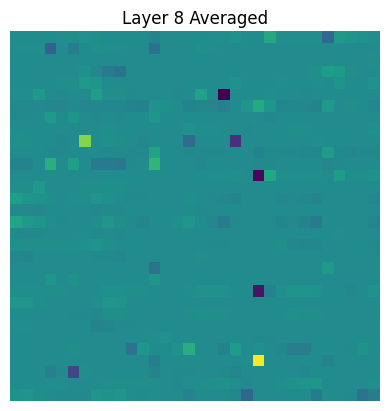

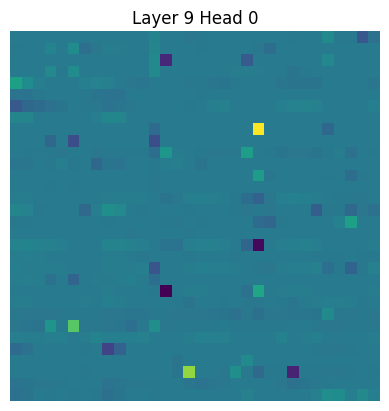

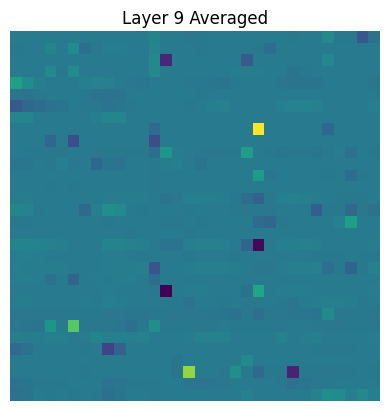

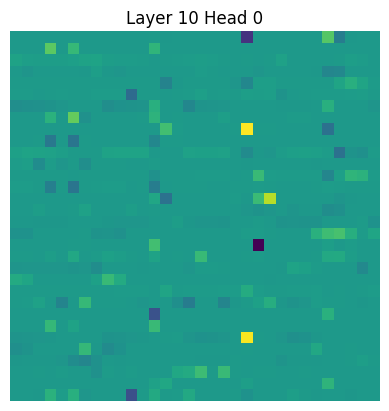

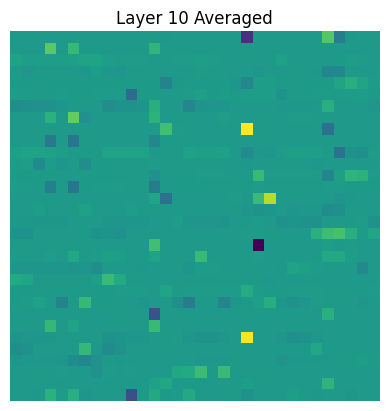

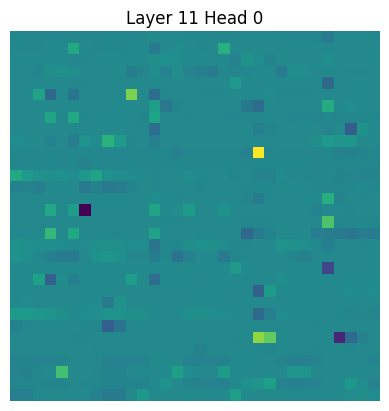

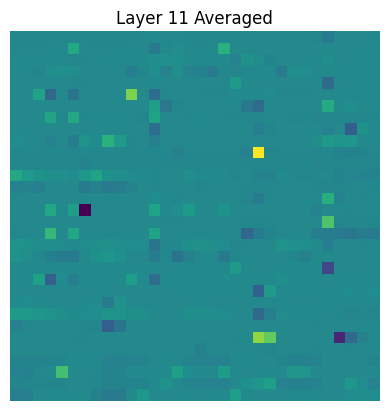

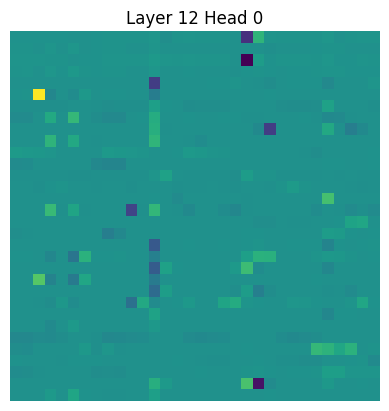

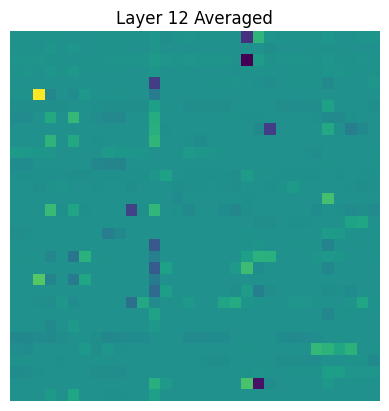

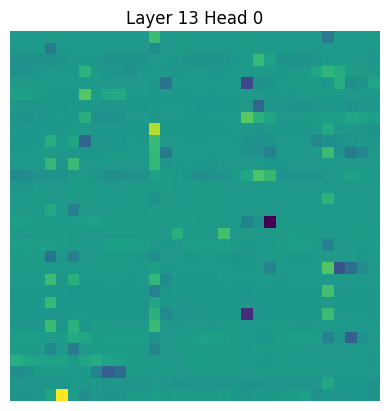

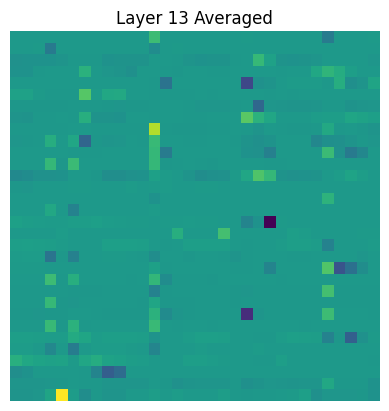

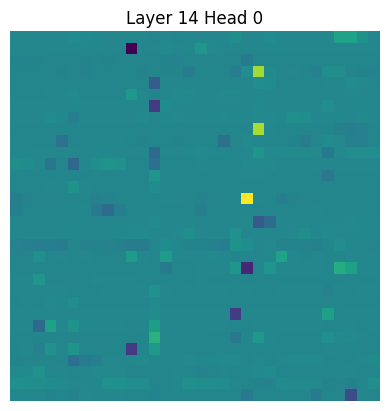

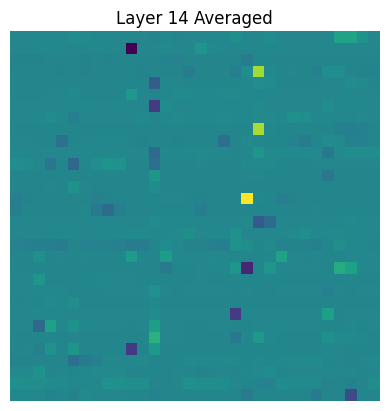

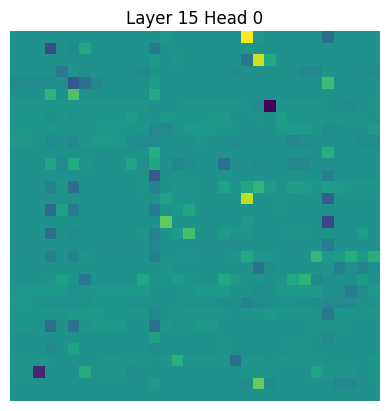

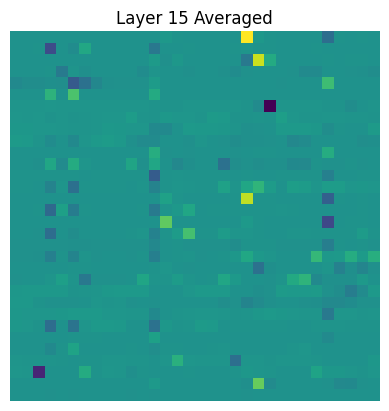

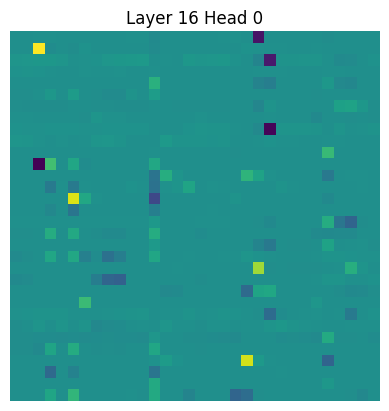

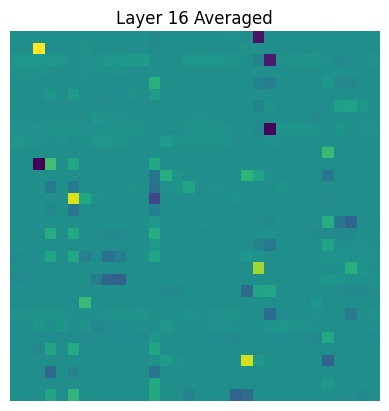

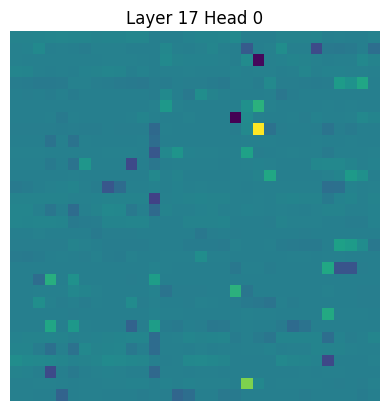

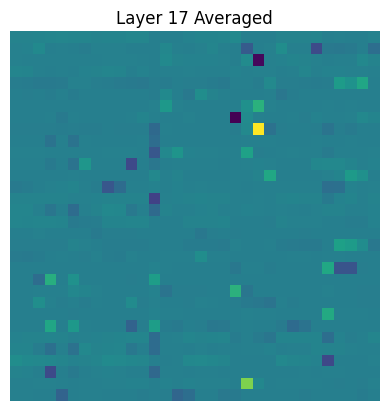

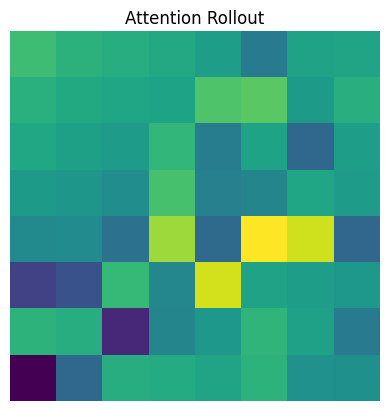

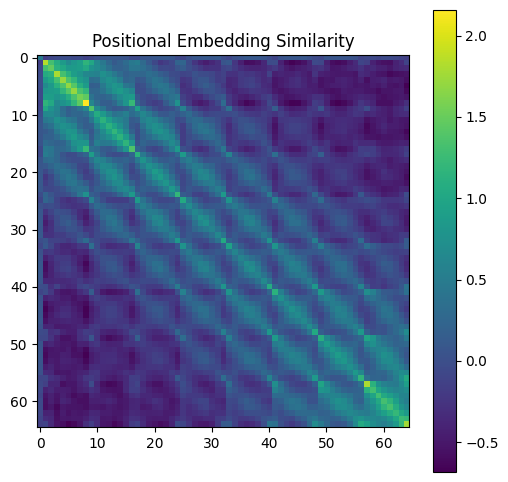

: 

In [ ]:
def unwrap_model(model):
    while hasattr(model, "module"):
        model = model.module
    return model

def unnormalize(img_tensor, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    img = img_tensor.cpu().numpy().transpose(1,2,0)
    return np.clip(std * img + mean, 0, 1)

# VisionTransformer.get_last_attention_map
def _get_last_attention_map(self, x):
    B, device = x.shape[0], x.device
    x = self.patch_embed(x)
    cls = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls, x), dim=1)
    if self.pos_emb_type in ["1d","sinusoidal"]:
        x = x + self.pos_embed
    elif self.pos_emb_type == "2d":
        gs = int(math.sqrt(x.shape[1]-1))
        pp = torch.cat((self.row_embed.repeat(1,gs,1),
                        self.col_embed.repeat(1,gs,1)), dim=-1)
        pos = torch.cat((torch.zeros(1,1,pp.size(-1), device=device), pp), dim=1)
        x = x + pos
    x = self.dropout(x)
    for blk in self.blocks[:-1]:
        x = blk(x)
    lb = self.blocks[-1]
    x_norm = lb.norm1(x)
    attn_mod = lb.attn
    if hasattr(attn_mod, "qkv"):
        _, attn = attn_mod(x_norm, return_attn=True)
    else:
        B2,N,C = x_norm.shape
        nh, hd, sc = attn_mod.num_heads, attn_mod.head_dim, attn_mod.scale
        q = attn_mod.q(x_norm).view(B2,N,nh,2*hd).transpose(1,2)
        k = attn_mod.k(x_norm).view(B2,N,nh,2*hd).transpose(1,2)
        Q1,Q2 = q[...,:hd], q[...,hd:]
        K1,K2 = k[...,:hd], k[...,hd:]
        s1 = (Q1 @ K1.transpose(-2,-1)) / sc
        s2 = (Q2 @ K2.transpose(-2,-1)) / sc
        attn = s1.softmax(-1) - attn_mod.lam * s2.softmax(-1)
    return attn  

# attach the patch to VisionTransformer class
VisionTransformer = unwrap_model(model).__class__
VisionTransformer.get_last_attention_map = _get_last_attention_map

# DINO‑style CLS to Patch Attention
def visualize_cls_patch_attention(model, img, patch_size):
    model.eval()
    with torch.no_grad():
        attn = model.get_last_attention_map(img)    
    attn = attn[0]                                 
    heads, _, _ = attn.shape
    cls2patch = attn[:,0,1:].detach().cpu().numpy()  
    patches = cls2patch.shape[-1]
    grid = int(math.sqrt(patches))
    maps = cls2patch.reshape(heads, grid, grid)
    up = F.interpolate(torch.from_numpy(maps).unsqueeze(1), scale_factor=patch_size, mode='nearest')[...,0]
    plt.figure(); plt.imshow(unnormalize(img[0])); plt.axis('off'); plt.title("Input Image")
    for h in range(heads):
        plt.figure(); plt.imshow(up[h].numpy(), cmap='viridis')
        plt.axis('off'); plt.title(f"Head {h}")
    plt.show()

# Last‑layer Attention Maps + Aggregate
def visualize_vit_attention_last(model, img):
    model.eval()
    with torch.no_grad():
        attn = model.get_last_attention_map(img)    
    attn = attn[0].detach().cpu().numpy()          
    heads = attn.shape[0]
    cls2 = attn[:,0,1:]
    patches = cls2.shape[-1]
    grid = int(math.sqrt(patches))
    maps = cls2.reshape(heads, grid, grid)
    plt.figure(); plt.imshow(unnormalize(img[0])); plt.axis('off'); plt.title("Input Image")
    for h in range(heads):
        plt.figure(); plt.imshow(maps[h], cmap='viridis')
        plt.axis('off'); plt.title(f"Head {h}")
    plt.figure(); plt.imshow(maps.mean(0), cmap='viridis')
    plt.axis('off'); plt.title("Averaged Attention")
    plt.show()

# All‑layers CLS to Patch Attention
def visualize_vit_attention_all_layers(model, img):
    model.eval()
    B, device = img.shape[0], img.device
    x = model.patch_embed(img)
    cls = model.cls_token.expand(B, -1, -1)
    x = torch.cat((cls, x), dim=1)
    if model.pos_emb_type in ["1d","sinusoidal"]:
        x = x + model.pos_embed
    elif model.pos_emb_type == "2d":
        gs = int(math.sqrt(x.shape[1]-1))
        pp = torch.cat((model.row_embed.repeat(1,gs,1), model.col_embed.repeat(1,gs,1)), dim=-1)
        pos = torch.cat((torch.zeros(1,1,pp.size(-1),device=device), pp), dim=1)
        x = x + pos
    x = model.dropout(x)
    for li, blk in enumerate(model.blocks):
        xn = blk.norm1(x)
        attn_mod = blk.attn
        if hasattr(attn_mod, "qkv"):
            _, attn = attn_mod(xn, return_attn=True)
        else:
            B2,N,C = xn.shape
            nh, hd, sc = attn_mod.num_heads, attn_mod.head_dim, attn_mod.scale
            q = attn_mod.q(xn).view(B2,N,nh,2*hd).transpose(1,2)
            k = attn_mod.k(xn).view(B2,N,nh,2*hd).transpose(1,2)
            Q1,Q2 = q[...,:hd], q[...,hd:]
            K1,K2 = k[...,:hd], k[...,hd:]
            s1 = (Q1 @ K1.transpose(-2,-1)) / sc
            s2 = (Q2 @ K2.transpose(-2,-1)) / sc
            attn = s1.softmax(-1) - attn_mod.lam * s2.softmax(-1)
        cls2 = attn[0,:,0,1:].detach().cpu().numpy()
        patches = cls2.size
        grid = int(math.sqrt(patches))
        maps = cls2.reshape(-1, grid, grid)
        for h in range(maps.shape[0]):
            plt.figure(); plt.imshow(maps[h], cmap='viridis')
            plt.axis('off'); plt.title(f"Layer {li} Head {h}")
        plt.figure(); plt.imshow(maps.mean(0), cmap='viridis')
        plt.axis('off'); plt.title(f"Layer {li} Averaged")
        x = blk(x)
    plt.show()

# Attention Rollout (fixed)
def visualize_rollout(model, img, discard_ratio=0.0):
    model.eval()
    B, device = img.shape[0], img.device
    nt = model.patch_embed.num_patches + 1
    R = torch.eye(nt, device=device).unsqueeze(0).repeat(B,1,1)
    x = model.patch_embed(img)
    cls = model.cls_token.expand(B, -1, -1)
    x = torch.cat((cls, x), dim=1)
    if model.pos_emb_type in ["1d","sinusoidal"]:
        x = x + model.pos_embed
    elif model.pos_emb_type == "2d":
        gs = int(math.sqrt(x.shape[1]-1))
        pp = torch.cat((model.row_embed.repeat(1,gs,1), model.col_embed.repeat(1,gs,1)), dim=-1)
        pos = torch.cat((torch.zeros(1,1,pp.size(-1),device=device), pp), dim=1)
        x = x + pos
    x = model.dropout(x)
    for blk in model.blocks:
        xn = blk.norm1(x)
        attn_mod = blk.attn
        if hasattr(attn_mod, "qkv"):
            _, attn = attn_mod(xn, return_attn=True)
        else:
            B2,N,C = xn.shape
            nh, hd, sc = attn_mod.num_heads, attn_mod.head_dim, attn_mod.scale
            q = attn_mod.q(xn).view(B2,N,nh,2*hd).transpose(1,2)
            k = attn_mod.k(xn).view(B2,N,nh,2*hd).transpose(1,2)
            Q1,Q2 = q[...,:hd], q[...,hd:]
            K1,K2 = k[...,:hd], k[...,hd:]
            s1 = (Q1 @ K1.transpose(-2,-1)) / sc
            s2 = (Q2 @ K2.transpose(-2,-1)) / sc
            attn = s1.softmax(-1) - attn_mod.lam * s2.softmax(-1)
        aa = attn.mean(1)
        if discard_ratio > 0:
            flat = aa.view(B, aa.size(1), -1)
            _, idx = flat.topk(int(flat.size(-1)*discard_ratio), dim=-1, largest=False)
            flat.scatter_(-1, idx, 0)
            aa = flat.view_as(aa)
        res = aa + torch.eye(aa.size(-1), device=device).unsqueeze(0)
        res = res / res.sum(-1, keepdim=True)
        R = R.bmm(res)
        x = blk(x)
    rollout_map = R[:,0,1:].reshape(B, int(math.sqrt(R.size(-1)-1)), -1).detach().cpu().numpy()
    plt.figure(); plt.imshow(rollout_map[0], cmap='viridis')
    plt.axis('off'); plt.title("Attention Rollout")
    plt.show()

# Positional Embedding Similarity
def visualize_pos_emb(model):
    if model.pos_emb_type not in ["1d","sinusoidal"]:
        print("Requires 1d or sinusoidal embeddings.")
        return
    pe = model.pos_embed[0]
    sim = pe @ pe.t()
    plt.figure(figsize=(6,6))
    plt.imshow(sim.cpu().detach().numpy(), cmap='viridis')
    plt.colorbar(); plt.title("Positional Embedding Similarity")
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = unwrap_model(model).to(device)
transform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])
ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True)
img, _ = next(iter(loader))
img = img.to(device)
patch_size = model.patch_embed.patch_size

visualize_cls_patch_attention(model, img, patch_size)
visualize_vit_attention_last(model, img)
visualize_vit_attention_all_layers(model, img)
visualize_rollout(model, img, discard_ratio=0.0)
visualize_pos_emb(model)

# Vision Transformer Interpretability 

---

## Input Image

The following visualizations are all based on the input image shown below, passed through a ViT encoder:

---

## Last-Layer CLS-to-Patch Attention (Per Head)

Each attention head attends differently to spatial patches. This provides insight into **what parts of the image each head focuses on for classification**.

> **Observation**: Many heads focus on distinct spatial parts like the beak, belly, or background, suggesting diverse attention patterns.

---

## Averaged Attention Map

The mean of all heads in the last layer gives a smooth and interpretable heatmap of what the model deems most important.

>  **Interpretation**: The averaged attention is highly concentrated on the bird's body and head, indicating that these patches are most influential in the classification decision.

---

## Layer-wise Attention Evolution

The CLS-to-patch attention maps across layers (Head 0 and averaged) show how focus changes over depth.

> **Trend**: Early layers are diffuse, while later layers concentrate attention around salient object regions.

---

## Attention Rollout

Rollout maps track the flow of information from all patches to the [CLS] token across **all layers**, simulating a composite attention map.

> **Insight**: The attention is strongest on the central part of the bird — confirming deep-layer consensus on the classification-relevant region.

---

## Positional Embedding Similarity

This matrix compares dot-product similarity between learned positional embeddings.

> **Interpretation**:
- Clear diagonals show that the model maintains **relative position encoding**.
- Subtle off-diagonal bands suggest periodicity or structured symmetry.

---